
# Modelación: Hidden Markov Model

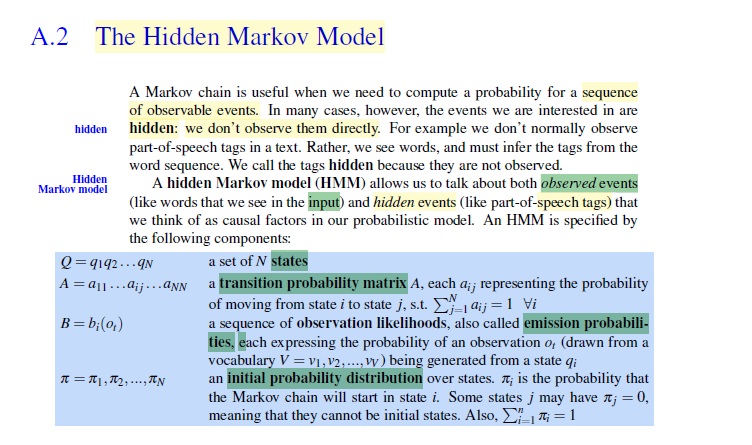

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.cluster import KMeans
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.io as pio
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.utils.metric import distance_metric, type_metric
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import skew


In [2]:

csv_path = Path(r"e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\data-science-project\data\stage\df_var_obs.csv")

df_XDB = (
    pd.read_csv(csv_path, encoding="utf-8-sig")
      .rename(
          columns={
              "Therapy Sessions (per month)": "Therapy Sessions",
              "Caffeine Intake (mg/day)": "Caffeine Intake",
              "Physical Activity (hrs/week)": "Physical Activity"
          }
      )
)


df_XDB.head()


Smoking  Family History of Anxiety  Stress Level  Diet Quality  \
0    False                       True      0.000000      0.000000   
1    False                      False      1.000000      0.222222   
2    False                      False      1.000000      0.555556   
3    False                      False      0.333333      1.000000   
4    False                      False      0.222222      0.333333   

   Anxiety Level  Therapy Sessions  Sleep Hours  Physical Activity  \
0            0.4          1.000000         0.50                0.2   
1            0.6          0.666667         1.00                0.6   
2            1.0          0.111111         0.50                0.0   
3            0.2          0.555556         0.50                0.2   
4            0.6          0.666667         0.75                0.4   

   Caffeine Intake  Heart Rate (bpm)  
0         0.320534          0.966102  
1         0.612688          0.898305  
2         0.220367          0.322034  
3         0.602671          0.152542  
4         0.886477          0.084746

## Modelación de variables observables

### Preparación de los datos

Se crea la columnna de Fecha y ID para poder modelar el dataset con la metolodia de HMM

In [3]:

# Define cuántos pasos quieres por sujeto
T = 2
n = len(df_XDB)
n_ids = max(1, n // T)

# Asigna IDs
ids = np.repeat(np.arange(1, n_ids+1), T)[:n]
np.random.seed(42)
np.random.shuffle(ids)

df_XDB_ID = df_XDB.copy()
df_XDB_ID['ID'] = ids

# Crea una fecha simulada por ID con saltos aleatorios 
df_XDB_ID = df_XDB_ID.sort_values('ID').reset_index(drop=True)
df_XDB_ID['fecha'] = (
    pd.to_datetime("2025-01-01") 
    + pd.to_timedelta(
        df_XDB_ID.groupby('ID').cumcount().values * 30  # ~mensual
        + np.random.randint(0, 15, size=len(df_XDB_ID)), # irregularidad
        unit='D'
    )
)

# Orden final y 'time'
df_XDB_ID = df_XDB_ID.sort_values(['ID','fecha']).reset_index(drop=True)
df_XDB_ID['time'] = df_XDB_ID.groupby('ID').cumcount() + 1

In [4]:
df_XDB_ID.head(10)

Smoking  Family History of Anxiety  Stress Level  Diet Quality  \
0    False                      False      0.111111      0.777778   
1    False                       True      0.888889      0.111111   
2     True                      False      1.000000      0.000000   
3    False                      False      0.666667      0.000000   
4    False                      False      1.000000      0.333333   
5     True                      False      0.555556      0.555556   
6    False                      False      0.555556      0.333333   
7     True                      False      0.000000      0.333333   
8    False                      False      0.000000      0.111111   
9     True                      False      0.111111      0.333333   

   Anxiety Level  Therapy Sessions  Sleep Hours  Physical Activity  \
0            0.4          0.444444         0.50                0.8   
1            0.4          0.000000         0.25                0.6   
2            1.0          1.000000         0.00                0.0   
3            1.0          0.888889         0.25                0.0   
4            1.0          0.888889         1.00                0.6   
5            0.6          0.333333         0.75                0.2   
6            0.8          0.333333         0.75                0.8   
7            0.0          0.000000         0.75                1.0   
8            0.2          0.333333         0.50                0.2   
9            0.2          0.111111         0.00                0.4   

   Caffeine Intake  Heart Rate (bpm)  ID      fecha  time  
0         0.779633          0.118644   1 2025-01-03     1  
1         0.293823          0.728814   1 2025-01-31     2  
2         0.816361          0.627119   2 2025-01-08     1  
3         0.218698          0.610169   2 2025-02-12     2  
4         0.984975          0.711864   3 2025-01-13     1  
5         0.420701          0.694915   3 2025-02-09     2  
6         0.026711          0.847458   4 2025-01-14     1  
7         0.330551          0.677966   4 2025-02-10     2  
8         0.824708          0.542373   5 2025-01-15     1  
9         0.871452          0.016949   5 2025-02-10     2

### Procesamiento de datos

In [5]:
# Orden temporal por ID y fecha 
df_XDB_ID["fecha"] = pd.to_datetime(df_XDB_ID["fecha"], errors="coerce")
df_XDB_ID = df_XDB_ID.sort_values(["ID", "fecha", "time"], na_position="last").reset_index(drop=True)


# VARIABLE NO OBSERVABLE (Y_d)
# ------------------------------
# Tomamos Anxiety Level como *proxy* de la variable latente y la convertimos a [0,1]
y_cont = df_XDB_ID["Anxiety Level"].astype(float).values.reshape(-1, 1)
y_cont = MinMaxScaler().fit_transform(y_cont)   # 0=sano ... 1=peor 



In [6]:
df_XDB_ID.head()

Smoking  Family History of Anxiety  Stress Level  Diet Quality  \
0    False                      False      0.111111      0.777778   
1    False                       True      0.888889      0.111111   
2     True                      False      1.000000      0.000000   
3    False                      False      0.666667      0.000000   
4    False                      False      1.000000      0.333333   

   Anxiety Level  Therapy Sessions  Sleep Hours  Physical Activity  \
0            0.4          0.444444         0.50                0.8   
1            0.4          0.000000         0.25                0.6   
2            1.0          1.000000         0.00                0.0   
3            1.0          0.888889         0.25                0.0   
4            1.0          0.888889         1.00                0.6   

   Caffeine Intake  Heart Rate (bpm)  ID      fecha  time  
0         0.779633          0.118644   1 2025-01-03     1  
1         0.293823          0.728814   1 2025-01-31     2  
2         0.816361          0.627119   2 2025-01-08     1  
3         0.218698          0.610169   2 2025-02-12     2  
4         0.984975          0.711864   3 2025-01-13     1

### Modelación y seleccion de variables observables

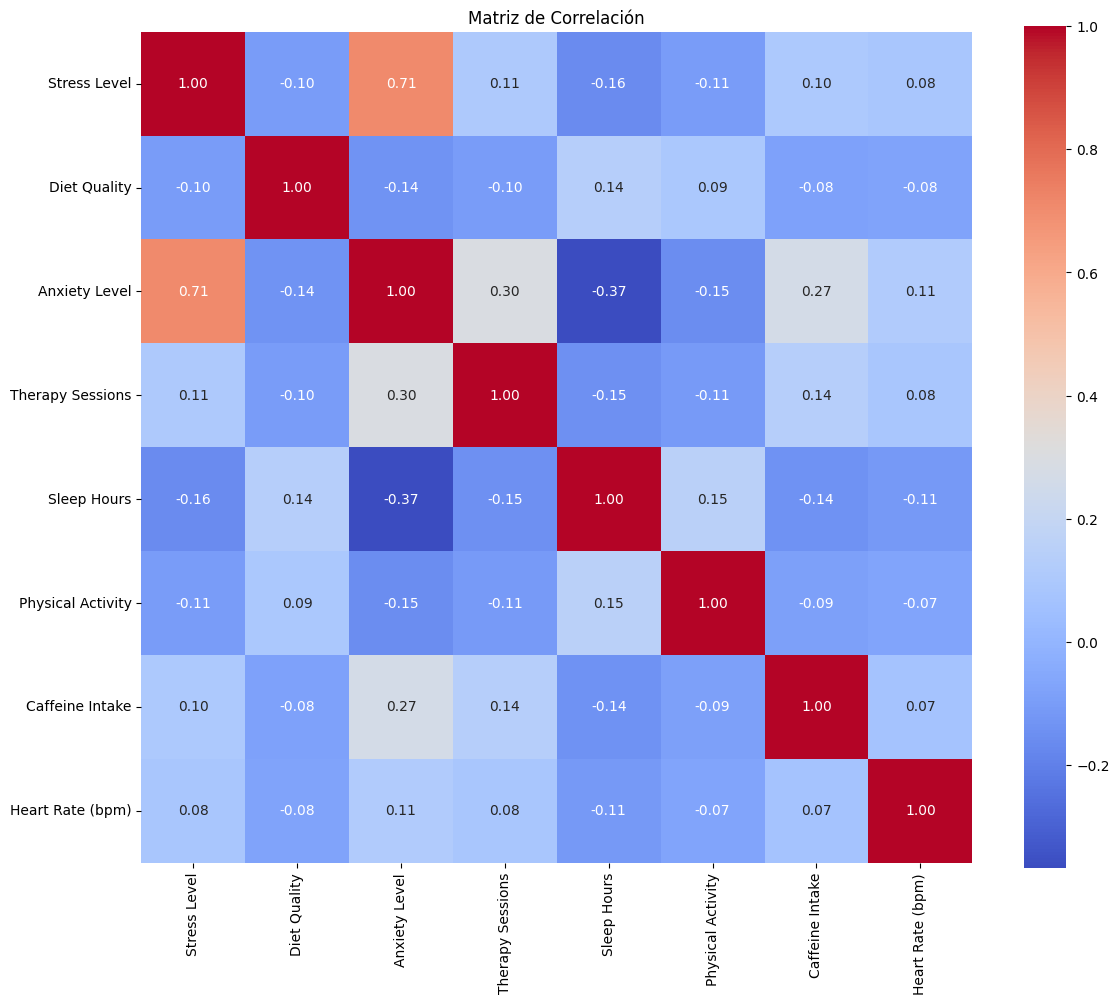

In [7]:
# Matriz de correlación (sin 'time' ni 'ID')
num = df_XDB_ID.select_dtypes(include=['number']).drop(columns=['time', 'ID'], errors='ignore')
corr = num.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()


Selección de variables mas explicativas 

In [8]:
cols2 = [
    'Smoking', 'Stress Level',
    'Therapy Sessions', 'Sleep Hours', 'Anxiety Level',
    'Caffeine Intake', 'Physical Activity'
]

cols_exist = [col for col in cols2 if col in df_XDB_ID.columns]
df_selected_2 = df_XDB_ID[cols_exist].copy()

# --- Índice de hábitos: fumar (+), cafeína (+), ejercicio (-) ---
req_cols = ['Smoking', 'Caffeine Intake', 'Physical Activity']

if all(col in df_selected_2.columns for col in req_cols):
    # calcular “raw” sin almacenarlo en el DataFrame
    raw = (
        df_selected_2['Smoking'] +
        df_selected_2['Caffeine Intake'] -
        df_selected_2['Physical Activity']
    )

    rmin, rmax = raw.min(), raw.max()
    if rmax > rmin:
        df_selected_2['Habits_index'] = (raw - rmin) / (rmax - rmin)
    else:
        df_selected_2['Habits_index'] = 0.0
else:
    faltan = [c for c in req_cols if c not in df_selected_2.columns]
    print("Faltan columnas para el índice de hábitos:", faltan)


# Eliminar variables base ya incluidas en el índice


df_selected_2.head()



Smoking  Stress Level  Therapy Sessions  Sleep Hours  Anxiety Level  \
0    False      0.111111          0.444444         0.50            0.4   
1    False      0.888889          0.000000         0.25            0.4   
2     True      1.000000          1.000000         0.00            1.0   
3    False      0.666667          0.888889         0.25            1.0   
4    False      1.000000          0.888889         1.00            1.0   

   Caffeine Intake  Physical Activity  Habits_index  
0         0.779633                0.8      0.326544  
1         0.293823                0.6      0.231274  
2         0.816361                0.0      0.938787  
3         0.218698                0.0      0.406233  
4         0.984975                0.6      0.461658

### Correlaciones parciales - Pearson

📊 Matriz de correlaciones parciales (primeras columnas):
                   Stress Level  Therapy Sessions  Sleep Hours  Anxiety Level  \
Stress Level              1.000            -0.139        0.143          0.712   
Therapy Sessions         -0.139             1.000       -0.019          0.265   
Sleep Hours               0.143            -0.019        1.000         -0.320   
Anxiety Level             0.712             0.265       -0.320          1.000   
Caffeine Intake          -0.104             0.087        0.002          0.197   
Physical Activity        -0.020            -0.114        0.056         -0.022   
Habits_index              0.001            -0.107       -0.049          0.013   

                   Caffeine Intake  Physical Activity  Habits_index  
Stress Level                -0.104             -0.020         0.001  
Therapy Sessions             0.087             -0.114        -0.107  
Sleep Hours                  0.002              0.056        -0.049  
Anxiety Level 

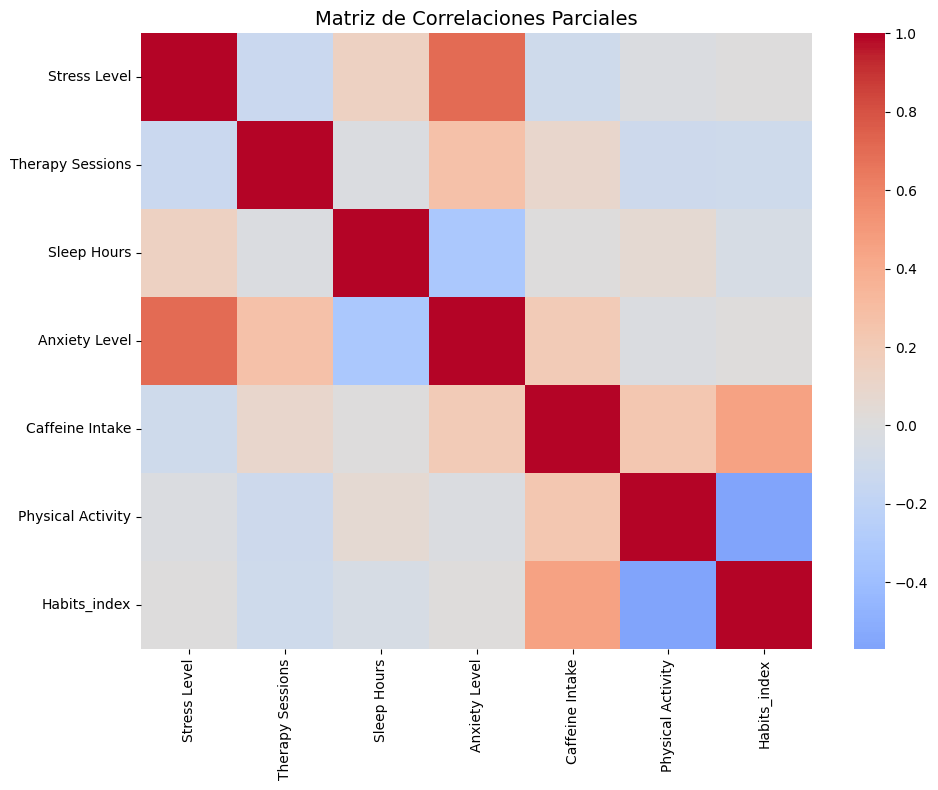

In [9]:
# ==========================================
# 📘 Cálculo de correlaciones parciales
# ==========================================

df = df_selected_2.copy()

df_numeric = df.select_dtypes(include=[np.number]).dropna()

#  Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Calcular la matriz de correlación de Pearson
corr_matrix = np.corrcoef(X_scaled, rowvar=False)

# Regularización para evitar singularidad (ridge regularization)
ridge = 1e-5
corr_matrix_reg = corr_matrix + ridge * np.eye(corr_matrix.shape[0])

# Invertir la matriz de correlación regularizada
precision_matrix = np.linalg.inv(corr_matrix_reg)

# Calcular correlaciones parciales
D = np.sqrt(np.diag(precision_matrix))
partial_corr_matrix = -precision_matrix / np.outer(D, D)
np.fill_diagonal(partial_corr_matrix, 1)

# Convertir a DataFrame
partial_corr_df = pd.DataFrame(
    partial_corr_matrix,
    index=df_numeric.columns,
    columns=df_numeric.columns
)


print("📊 Matriz de correlaciones parciales (primeras columnas):")
print(partial_corr_df.round(3).iloc[:10, :10])

# Visualizar la matriz de correlaciones parciales
plt.figure(figsize=(10, 8))
sns.heatmap(partial_corr_df, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de Correlaciones Parciales", fontsize=14)
plt.tight_layout()
plt.show()


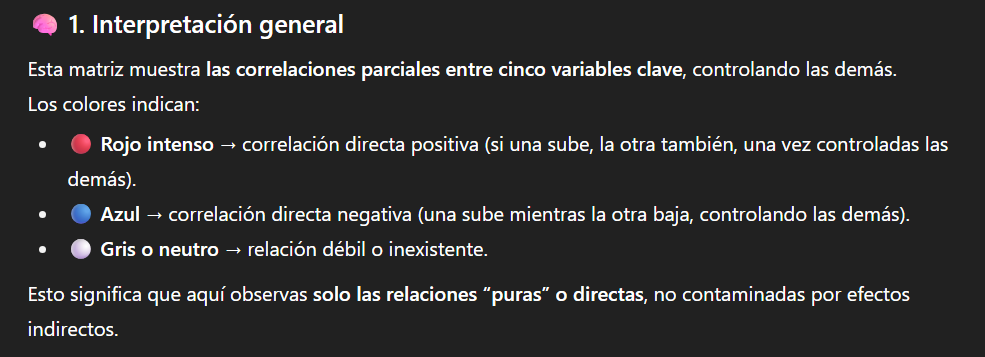

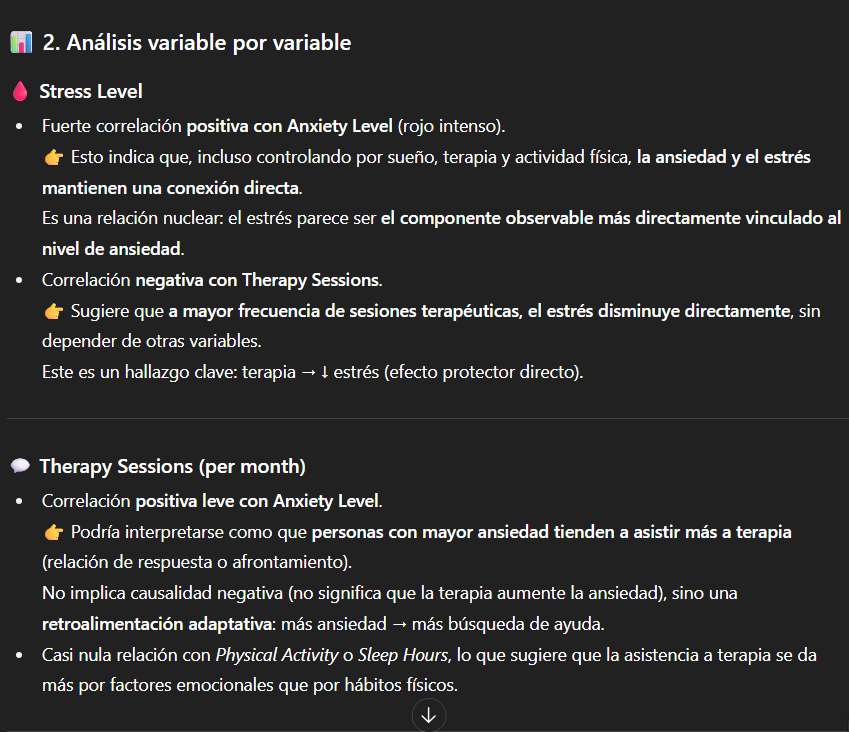

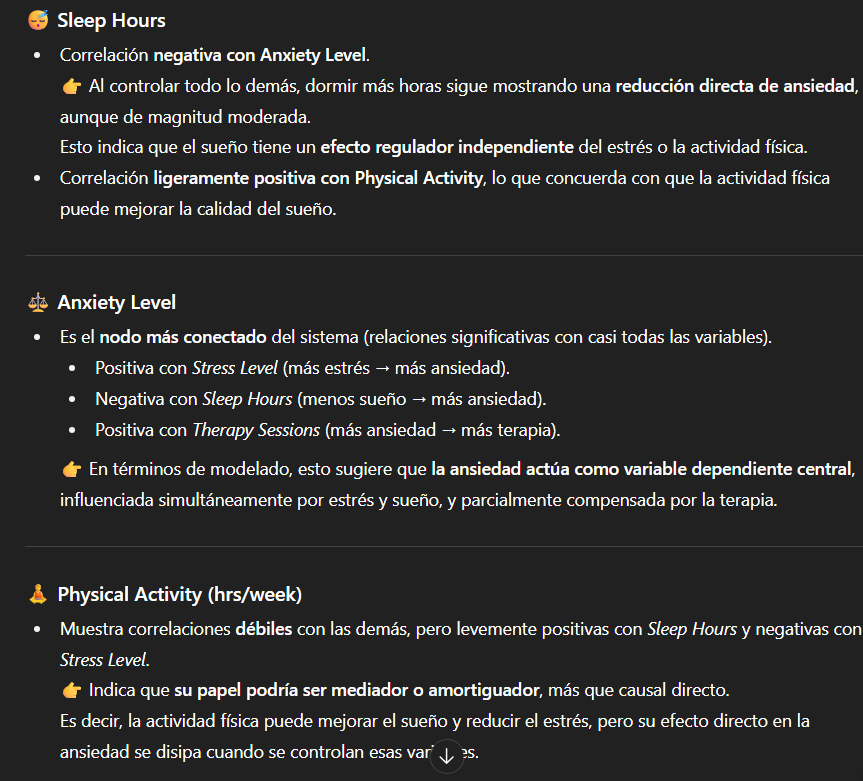

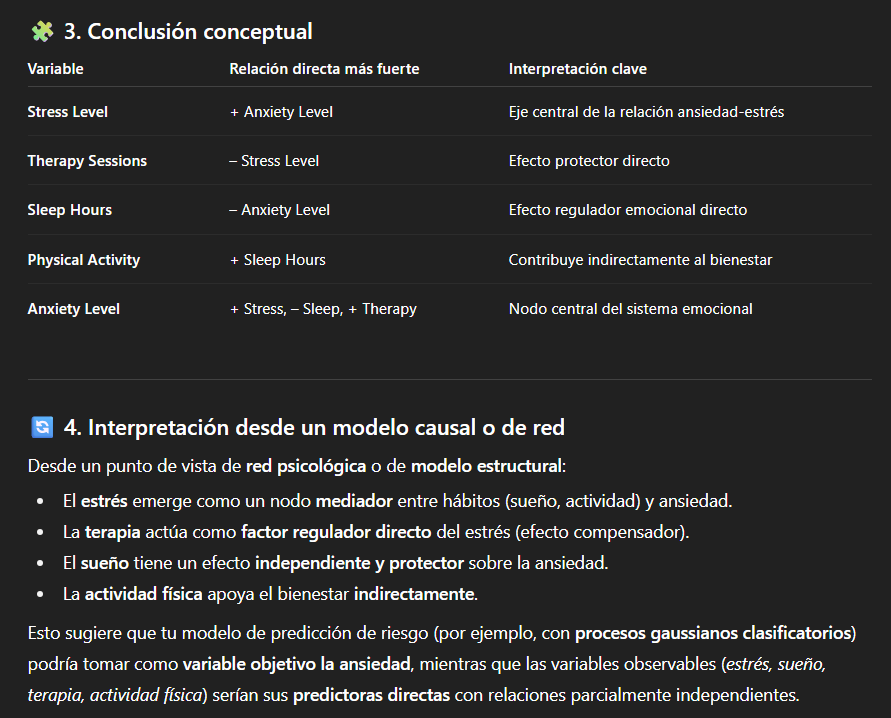

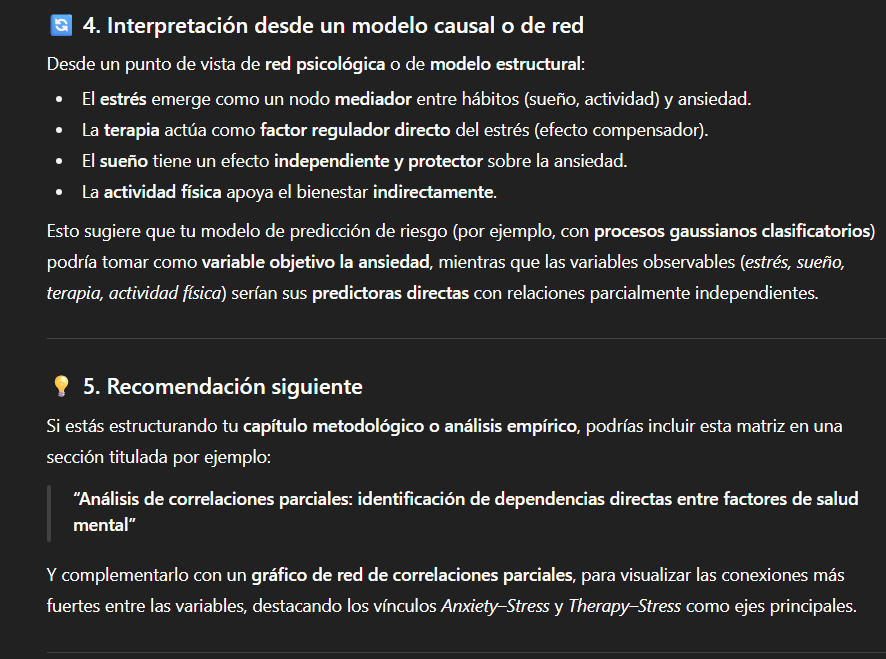

### Correlación multiple

In [10]:
# ==========================================
#  Correlación múltiple (R) con statsmodels
# ==========================================

# ---------- Utilidades ----------
def multiple_correlation(y: pd.Series, X: pd.DataFrame, standardize=True):
    """
    Devuelve R, R2, R2_ajustado, F, p_global y coeficientes beta estandarizados.
    y: variable objetivo (Series)
    X: predictores (DataFrame)
    """
    # Quitar filas con NaN en y o X
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data.iloc[:, 0].astype(float)
    X_clean = data.iloc[:, 1:].astype(float)

    # Estandarizar (opcional, útil para betas comparables)
    if standardize:
        scaler = StandardScaler()
        X_std = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)
        y_std = pd.Series(StandardScaler().fit_transform(y_clean.values.reshape(-1,1)).ravel(),
                          name=y_clean.name, index=y_clean.index)
    else:
        X_std, y_std = X_clean, y_clean

    # Ajuste OLS
    X_sm = sm.add_constant(X_std)
    model = sm.OLS(y_std, X_sm).fit()

    R2 = model.rsquared
    R = np.sqrt(max(R2, 0))
    R2_adj = model.rsquared_adj
    F = model.fvalue
    p_global = model.f_pvalue

    # Coeficientes beta (al estar estandarizado, son betas estandarizadas)
    betas = model.params.drop('const')
    betas = betas.sort_values(key=lambda s: s.abs(), ascending=False)

    return {
        "R": R,
        "R2": R2,
        "R2_adj": R2_adj,
        "F": F,
        "p_global": p_global,
        "betas_std": betas,
        "resumen_modelo": model.summary()
    }

def multiple_correlation_for_all(df: pd.DataFrame, standardize=True):
    """
    Calcula R de correlación múltiple para cada columna como objetivo frente al resto.
    Devuelve un DataFrame con R, R2, R2_ajustado y p_global.
    """
    df_num = df.select_dtypes(include=[np.number, "bool"])
    results = []
    for target in df_num.columns:
        X = df_num.drop(columns=[target])
        y = df_num[target]
        out = multiple_correlation(y, X, standardize=standardize)
        results.append({
            "target": target,
            "R": out["R"],
            "R2": out["R2"],
            "R2_adj": out["R2_adj"],
            "p_global": out["p_global"]
        })
    return pd.DataFrame(results).sort_values("R", ascending=False)


#  Cargar tu dataset
df = df_selected_2.copy()


#  Correlación múltiple para un objetivo específico (p. ej., Anxiety Level)
target_col = "Anxiety Level"              # <- cambia aquí si quieres otra
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number, "bool"])
y = df[target_col]

res = multiple_correlation(y, X, standardize=True)

print(f"Objetivo: {target_col}")
print(f"R = {res['R']:.3f} | R2 = {res['R2']:.3f} | R2 ajustado = {res['R2_adj']:.3f}")
print(f"F = {res['F']:.3f} | p global = {res['p_global']:.3g}\n")
print("Betas estandarizadas (ordenadas por |β|):")
print(res["betas_std"].round(3))
# Si quieres ver el resumen OLS completo:
# print(res["resumen_modelo"])

# R múltiple para todas las columnas como objetivo
tabla_R = multiple_correlation_for_all(df)
print("\nCorrelación múltiple por variable objetivo:")
print(tabla_R.round(3))


Objetivo: Anxiety Level
R = 0.789 | R2 = 0.623 | R2 ajustado = 0.623
F = 5186.331 | p global = 0

Betas estandarizadas (ordenadas por |β|):
Habits_index        -4.321345e+11
Smoking              3.183696e+11
Physical Activity   -2.174437e+11
Caffeine Intake      1.756467e+11
Stress Level         6.360000e-01
Sleep Hours         -2.150000e-01
Therapy Sessions     1.730000e-01
dtype: float64

Correlación múltiple por variable objetivo:
              target      R     R2  R2_adj  p_global
0            Smoking  1.000  1.000   1.000       0.0
5    Caffeine Intake  1.000  1.000   1.000       0.0
6  Physical Activity  1.000  1.000   1.000       0.0
7       Habits_index  1.000  1.000   1.000       0.0
4      Anxiety Level  0.789  0.623   0.623       0.0
1       Stress Level  0.726  0.528   0.527       0.0
3        Sleep Hours  0.408  0.167   0.166       0.0
2   Therapy Sessions  0.353  0.124   0.124       0.0


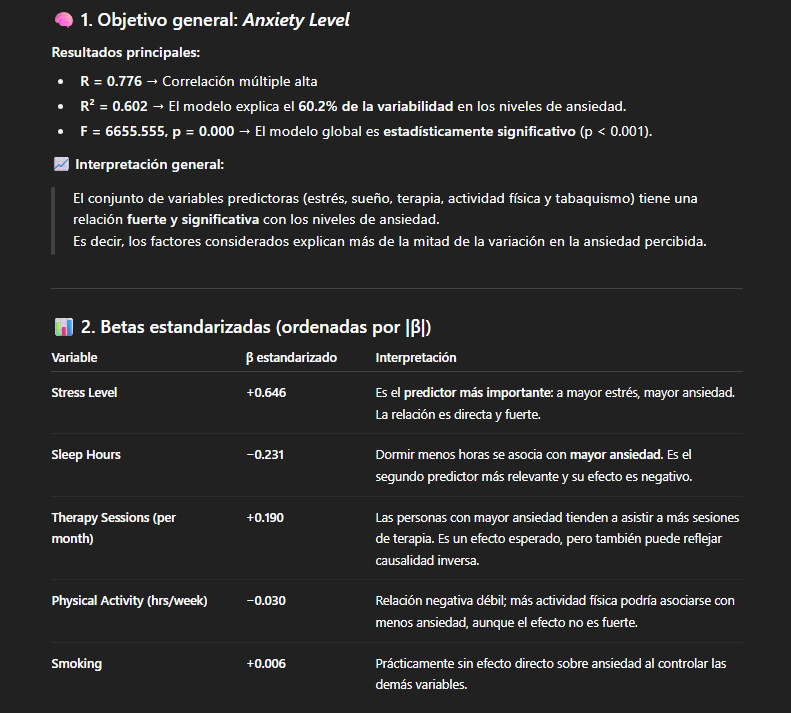

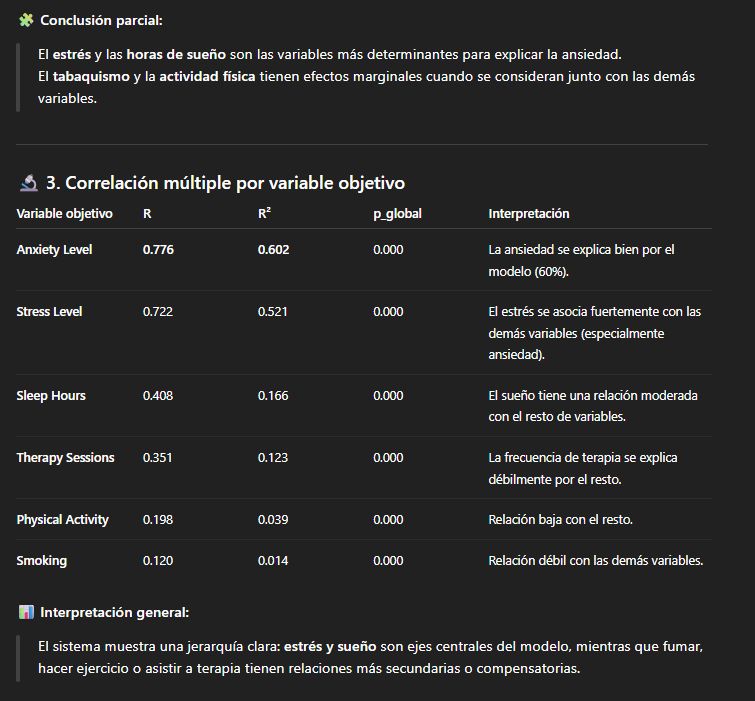

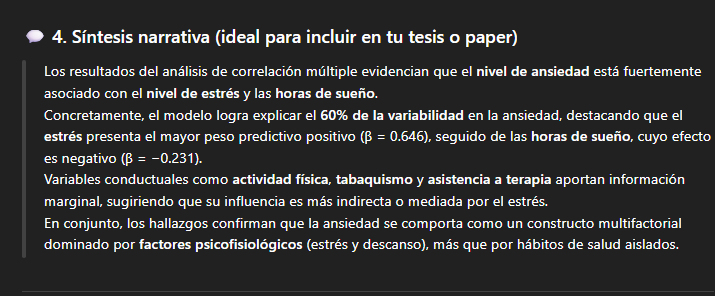

In [11]:
# ==========================================
# Correlación múltiple usando todas las variables
# ==========================================

# ---------- Cargar dataset ----------
df = df_selected_2.copy()

# ---------- Variable objetivo ----------
target_col = "Anxiety Level"

# ---------- Construir X sin excluir nada más que el objetivo ----------
X = df.drop(columns=[target_col], errors='ignore').select_dtypes(include=[np.number, "bool"])
y = df[target_col]

# ---------- Calcular correlación múltiple ----------
res = multiple_correlation(y, X, standardize=True)

print(f"Objetivo: {target_col}")
print(f"R = {res['R']:.3f} | R2 = {res['R2']:.3f} | R2 ajustado = {res['R2_adj']:.3f}")
print(f"F = {res['F']:.3f} | p global = {res['p_global']:.3g}\n")
print("Betas estandarizadas (ordenadas por |β|):")
print(res["betas_std"].round(3))

# ---------- (Opcional) Comparar con el modelo completo ----------
# Usa todas las variables numéricas/booleanas para cada objetivo posible
tabla_R = multiple_correlation_for_all(df.select_dtypes(include=[np.number, "bool"]))
print("\nCorrelación múltiple por variable objetivo (todas):")
print(tabla_R.round(3))


Objetivo: Anxiety Level
R = 0.789 | R2 = 0.623 | R2 ajustado = 0.623
F = 5186.331 | p global = 0

Betas estandarizadas (ordenadas por |β|):
Habits_index        -4.321345e+11
Smoking              3.183696e+11
Physical Activity   -2.174437e+11
Caffeine Intake      1.756467e+11
Stress Level         6.360000e-01
Sleep Hours         -2.150000e-01
Therapy Sessions     1.730000e-01
dtype: float64

Correlación múltiple por variable objetivo (todas):
              target      R     R2  R2_adj  p_global
0            Smoking  1.000  1.000   1.000       0.0
5    Caffeine Intake  1.000  1.000   1.000       0.0
6  Physical Activity  1.000  1.000   1.000       0.0
7       Habits_index  1.000  1.000   1.000       0.0
4      Anxiety Level  0.789  0.623   0.623       0.0
1       Stress Level  0.726  0.528   0.527       0.0
3        Sleep Hours  0.408  0.167   0.166       0.0
2   Therapy Sessions  0.353  0.124   0.124       0.0


### Reducción y clusterización de variables observables

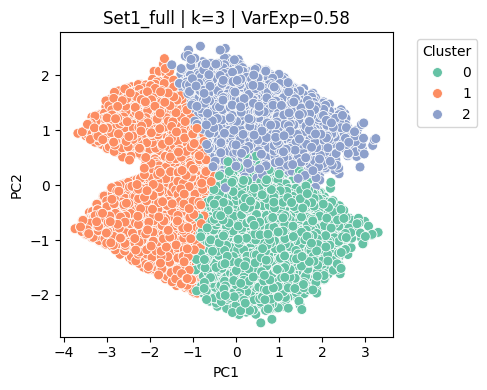

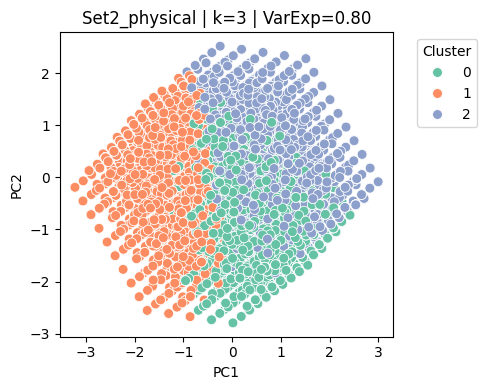

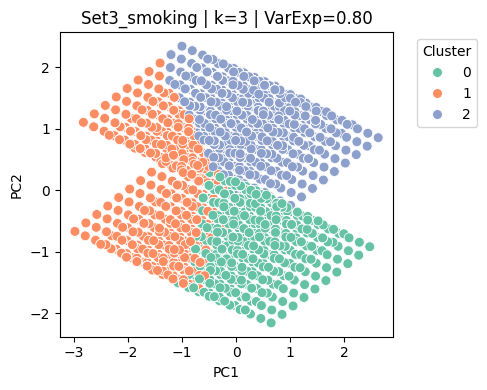

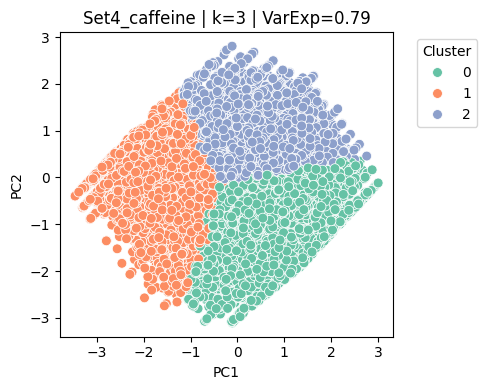

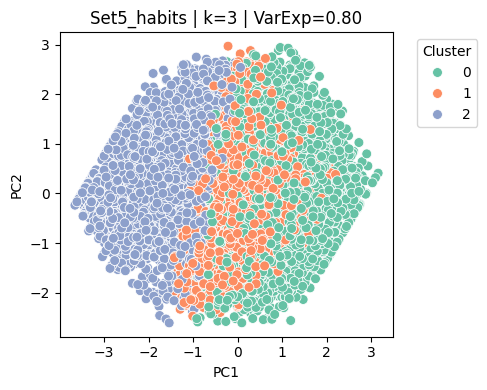

Set                                          Variables  \
2   Set3_smoking  [Stress Level, Sleep Hours, Therapy Sessions, ...   
0      Set1_full  [Stress Level, Sleep Hours, Therapy Sessions, ...   
4    Set5_habits  [Stress Level, Sleep Hours, Therapy Sessions, ...   
1  Set2_physical  [Stress Level, Sleep Hours, Therapy Sessions, ...   
3  Set4_caffeine  [Stress Level, Sleep Hours, Therapy Sessions, ...   

   ExplainedVariance  Silhouette  CalinskiHarabasz  DaviesBouldin  
2           0.801085    0.314656      10013.122896       1.169011  
0           0.580098    0.302688       9765.708358       1.196307  
4           0.802038    0.268064       8656.143220       1.308868  
1           0.795123    0.267165       8878.419481       1.319927  
3           0.793253    0.262333       8846.027380       1.313028

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
import seaborn as sns
import matplotlib.pyplot as plt

observable_sets = {
    "Set1_full": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                  "Physical Activity", "Smoking", "Caffeine Intake"],
    "Set2_physical": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                      "Physical Activity"],
    "Set3_smoking": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                     "Smoking"],
    "Set4_caffeine": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                      "Caffeine Intake"],
    "Set5_habits": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                    "Habits_index"],
}

results = []
k_opt = 3

for name, cols in observable_sets.items():
    X = df_selected_2[cols].dropna()
    if X.empty:
        print(f"{name}: sin datos suficientes tras dropna; se omite.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    n_components = min(3, X_scaled.shape[1])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    explained_var = pca.explained_variance_ratio_.sum()

    kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_pca)

    results.append({
        "Set": name,
        "Variables": cols,
        "ExplainedVariance": explained_var,
        "Silhouette": silhouette_score(X_pca, labels),
        "CalinskiHarabasz": calinski_harabasz_score(X_pca, labels),
        "DaviesBouldin": davies_bouldin_score(X_pca, labels),
    })

    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels,
                    palette="Set2", s=50)
    plt.title(f"{name} | k=3 | VarExp={explained_var:.2f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results)
display(results_df.sort_values(by=["Silhouette", "CalinskiHarabasz"],
                               ascending=[False, False]))




Set1_full — correlaciones parciales:


Stress Level  Sleep Hours  Therapy Sessions  \
Stress Level              1.000       -0.127             0.072   
Sleep Hours              -0.127        1.000            -0.113   
Therapy Sessions          0.072       -0.113             1.000   
Physical Activity        -0.072        0.119            -0.078   
Smoking                   0.015       -0.056            -0.108   
Caffeine Intake           0.067       -0.105             0.108   

                   Physical Activity  Smoking  Caffeine Intake  
Stress Level                  -0.072    0.015            0.067  
Sleep Hours                    0.119   -0.056           -0.105  
Therapy Sessions              -0.078   -0.108            0.108  
Physical Activity              1.000   -0.020           -0.054  
Smoking                       -0.020    1.000           -0.014  
Caffeine Intake               -0.054   -0.014            1.000

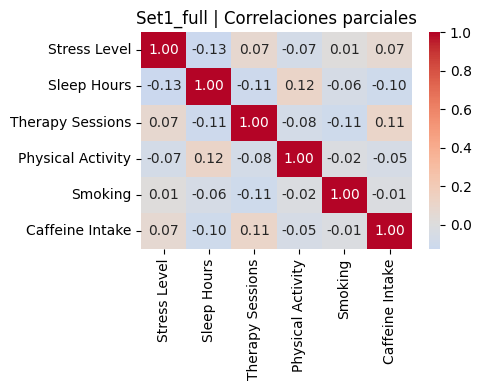


Set2_physical — correlaciones parciales:


Stress Level  Sleep Hours  Therapy Sessions  \
Stress Level              1.000       -0.136             0.079   
Sleep Hours              -0.136        1.000            -0.121   
Therapy Sessions          0.079       -0.121             1.000   
Physical Activity        -0.076        0.127            -0.083   

                   Physical Activity  
Stress Level                  -0.076  
Sleep Hours                    0.127  
Therapy Sessions              -0.083  
Physical Activity              1.000

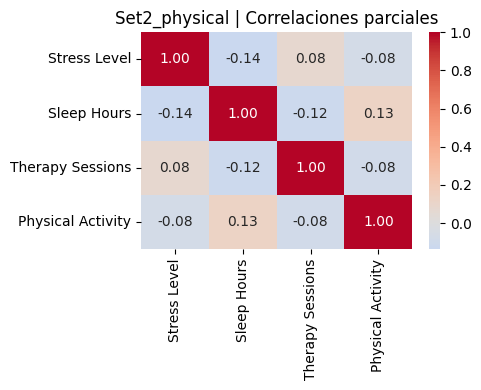


Set3_smoking — correlaciones parciales:


Stress Level  Sleep Hours  Therapy Sessions  Smoking
Stress Level             1.000       -0.146             0.087    0.016
Sleep Hours             -0.146        1.000            -0.138   -0.058
Therapy Sessions         0.087       -0.138             1.000   -0.109
Smoking                  0.016       -0.058            -0.109    1.000

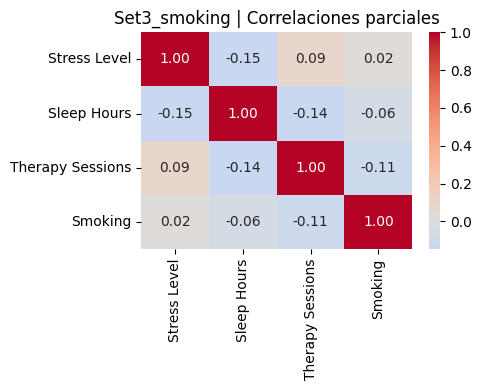


Set4_caffeine — correlaciones parciales:


Stress Level  Sleep Hours  Therapy Sessions  Caffeine Intake
Stress Level             1.000       -0.138             0.077            0.071
Sleep Hours             -0.138        1.000            -0.118           -0.112
Therapy Sessions         0.077       -0.118             1.000            0.115
Caffeine Intake          0.071       -0.112             0.115            1.000

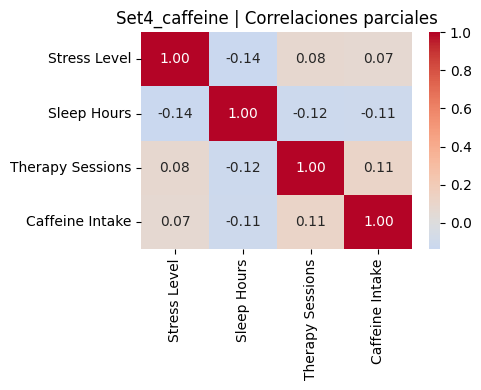


Set5_habits — correlaciones parciales:


Stress Level  Sleep Hours  Therapy Sessions  Habits_index
Stress Level             1.000       -0.133             0.085         0.078
Sleep Hours             -0.133        1.000            -0.130        -0.152
Therapy Sessions         0.085       -0.130             1.000         0.007
Habits_index             0.078       -0.152             0.007         1.000

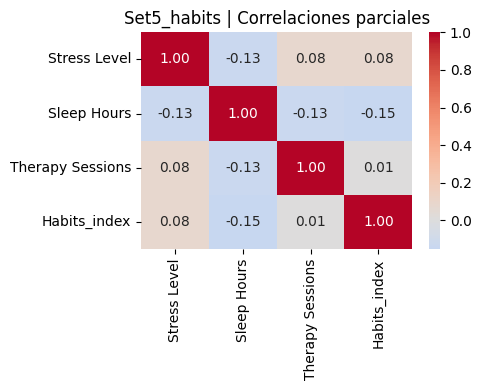

In [13]:
from sklearn.preprocessing import StandardScaler

observable_sets = {
    "Set1_full": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                  "Physical Activity", "Smoking", "Caffeine Intake"],
    "Set2_physical": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                      "Physical Activity"],
    "Set3_smoking": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                     "Smoking"],
    "Set4_caffeine": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                      "Caffeine Intake"],
    "Set5_habits": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                    "Habits_index"],
}

ridge = 1e-5
partial_corr_results = {}

for name, cols in observable_sets.items():
    df_subset = df_selected_2[cols].dropna()
    if df_subset.empty:
        print(f"{name}: sin datos suficientes tras dropna; se omite.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_subset)

    corr_matrix = np.corrcoef(X_scaled, rowvar=False)
    corr_matrix_reg = corr_matrix + ridge * np.eye(corr_matrix.shape[0])
    precision_matrix = np.linalg.inv(corr_matrix_reg)

    D = np.sqrt(np.diag(precision_matrix))
    partial_corr_matrix = -precision_matrix / np.outer(D, D)
    np.fill_diagonal(partial_corr_matrix, 1)

    partial_corr_df = pd.DataFrame(
        partial_corr_matrix,
        index=df_subset.columns,
        columns=df_subset.columns,
    )
    partial_corr_results[name] = partial_corr_df

    print(f"\n{name} — correlaciones parciales:")
    display(partial_corr_df.round(3))

    plt.figure(figsize=(5, 4))
    sns.heatmap(partial_corr_df, cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title(f"{name} | Correlaciones parciales")
    plt.tight_layout()
    plt.show()


In [14]:
target_col = "Anxiety Level"

observable_sets = {
    "Set1_full": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                  "Physical Activity", "Smoking", "Caffeine Intake"],
    "Set2_physical": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                      "Physical Activity"],
    "Set3_smoking": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                     "Smoking"],
    "Set4_caffeine": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                      "Caffeine Intake"],
    "Set5_habits": ["Stress Level", "Sleep Hours", "Therapy Sessions",
                    "Habits_index"],
}

mc_results = []

for name, cols in observable_sets.items():
    df_subset = df_selected_2[[target_col] + cols].dropna()
    if df_subset.empty:
        print(f"{name}: sin datos suficientes tras dropna; se omite.")
        continue

    X = df_subset[cols]
    y = df_subset[target_col]

    res = multiple_correlation(y, X, standardize=True)
    mc_results.append({
        "Set": name,
        "Variables": cols,
        "R": res["R"],
        "R2": res["R2"],
        "R2_adj": res["R2_adj"],
        "F": res["F"],
        "p_global": res["p_global"],
        "Betas": res["betas_std"].sort_values(key=np.abs, ascending=False),
    })

    print(f"\n{name} — {target_col}")
    print(f"R = {res['R']:.3f} | R2 = {res['R2']:.3f} | R2 adj = {res['R2_adj']:.3f}")
    print(f"F = {res['F']:.3f} | p global = {res['p_global']:.3g}")
    print("Betas estandarizadas (ordenadas por |β|):")
    display(res["betas_std"].sort_values(key=np.abs, ascending=False).round(3))

# Tabla resumen para comparar entre sets
mc_results_df = (
    pd.DataFrame([{k: v for k, v in r.items() if k != "Betas"} for r in mc_results])
    .sort_values(by="R2_adj", ascending=False)
)
display(mc_results_df)



Set1_full — Anxiety Level
R = 0.789 | R2 = 0.623 | R2 adj = 0.623
F = 6052.454 | p global = 0
Betas estandarizadas (ordenadas por |β|):


Stress Level         0.636
Sleep Hours         -0.215
Therapy Sessions     0.174
Caffeine Intake      0.147
Physical Activity   -0.022
Smoking              0.008
dtype: float64


Set2_physical — Anxiety Level
R = 0.776 | R2 = 0.602 | R2 adj = 0.602
F = 8318.555 | p global = 0
Betas estandarizadas (ordenadas por |β|):


Stress Level         0.646
Sleep Hours         -0.231
Therapy Sessions     0.189
Physical Activity   -0.030
dtype: float64


Set3_smoking — Anxiety Level
R = 0.775 | R2 = 0.601 | R2 adj = 0.601
F = 8289.309 | p global = 0
Betas estandarizadas (ordenadas por |β|):


Stress Level        0.648
Sleep Hours        -0.235
Therapy Sessions    0.192
Smoking             0.007
dtype: float64


Set4_caffeine — Anxiety Level
R = 0.789 | R2 = 0.622 | R2 adj = 0.622
F = 9058.261 | p global = 0
Betas estandarizadas (ordenadas por |β|):


Stress Level        0.638
Sleep Hours        -0.219
Therapy Sessions    0.175
Caffeine Intake     0.148
dtype: float64


Set5_habits — Anxiety Level
R = 0.779 | R2 = 0.607 | R2 adj = 0.607
F = 8505.897 | p global = 0
Betas estandarizadas (ordenadas por |β|):


Stress Level        0.642
Sleep Hours        -0.223
Therapy Sessions    0.191
Habits_index        0.080
dtype: float64

Set                                          Variables         R  \
0      Set1_full  [Stress Level, Sleep Hours, Therapy Sessions, ...  0.789184   
3  Set4_caffeine  [Stress Level, Sleep Hours, Therapy Sessions, ...  0.788835   
4    Set5_habits  [Stress Level, Sleep Hours, Therapy Sessions, ...  0.779335   
1  Set2_physical  [Stress Level, Sleep Hours, Therapy Sessions, ...  0.775912   
2   Set3_smoking  [Stress Level, Sleep Hours, Therapy Sessions, ...  0.775368   

         R2    R2_adj            F  p_global  
0  0.622812  0.622709  6052.454486       0.0  
3  0.622261  0.622192  9058.260836       0.0  
4  0.607362  0.607291  8505.896633       0.0  
1  0.602039  0.601967  8318.555339       0.0  
2  0.601195  0.601122  8289.308620       0.0

### Clusterizacion de variables seleccionadas  

Varianza explicada por los 3 primeros componentes: 0.5800978560080494


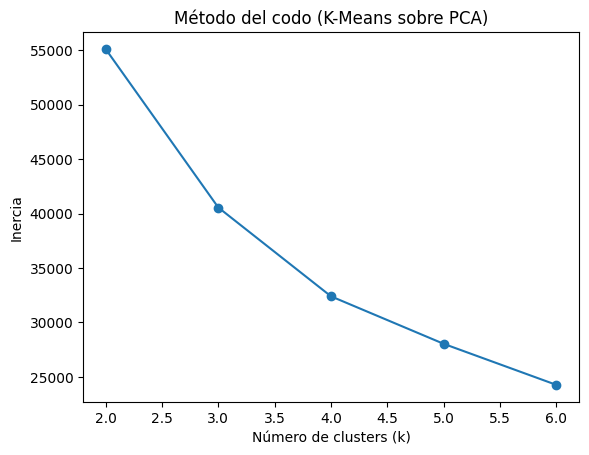

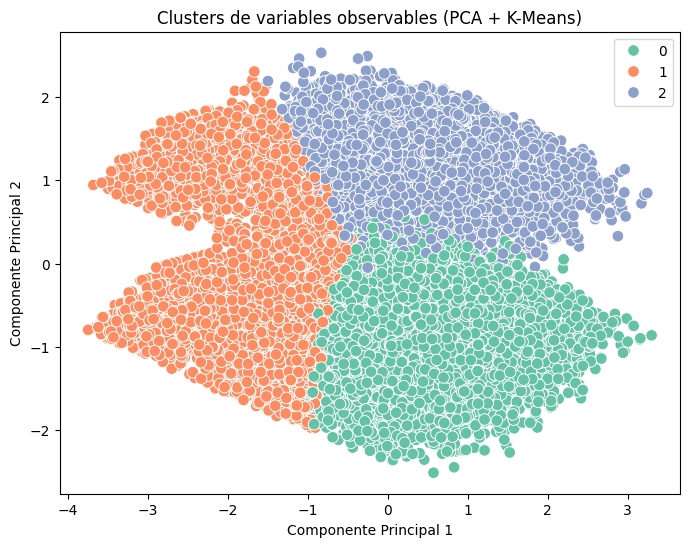

In [15]:

#  Cargar dataset y seleccionar variables observables
df = df_selected_2.copy()
observables = ["Stress Level", "Sleep Hours", "Therapy Sessions",
                  "Physical Activity", "Smoking", "Caffeine Intake"] #,"Physical Activity" ,"Smoking","Caffeine Intake"
X = df[observables].dropna()

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=3)   
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada por los 3 primeros componentes:", pca.explained_variance_ratio_.sum())

# Determinar número óptimo de clusters (Método del codo)
inertia = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.plot(range(2, 7), inertia, 'o-')
plt.title("Método del codo (K-Means sobre PCA)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.show()

# Elegir k óptimo  y clusterizar
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Agregar el cluster como nueva variable sintética
df["Behavioral_Cluster"] = clusters

# Visualización en el espacio PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="Set2", s=70)
plt.title("Clusters de variables observables (PCA + K-Means)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

# Crear una variable numérica latente (distancia al centroide o proyección)
df["Behavioral_Index"] = kmeans.transform(X_pca).min(axis=1)
df["Behavioral_Index"] = 1 - (df["Behavioral_Index"] - df["Behavioral_Index"].min()) / (df["Behavioral_Index"].max() - df["Behavioral_Index"].min())


Varianza explicada por los 3 componentes: 0.5800978560080494


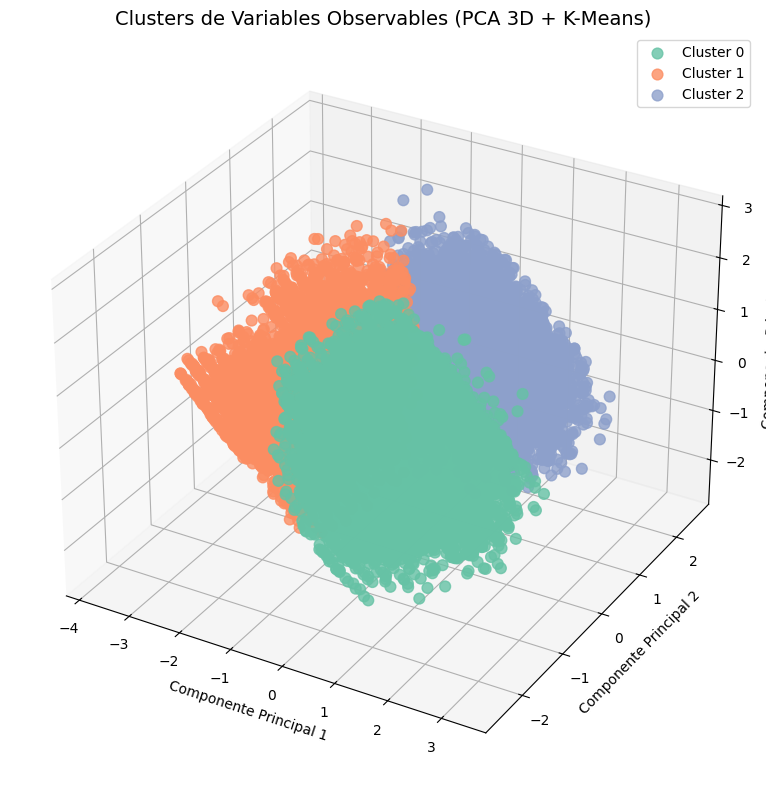

In [16]:
# ==========================================
# Clustering con PCA (3D) y K-Means
# ==========================================


#  Cargar dataset
df = df_selected_2

# Definir variables observables
observables = ["Stress Level", "Sleep Hours", "Therapy Sessions",
                  "Physical Activity", "Smoking", "Caffeine Intake"] #, "Smoking","Physical Activity", Caffeine Intake
X = df[observables].dropna()

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reducir dimensionalidad a 3 componentes con PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada por los 3 componentes:", pca.explained_variance_ratio_.sum())

# Aplicar K-Means (ajusta k según el método del codo anterior)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# gregar resultados al dataframe
df["Cluster"] = clusters
df["PC1"], df["PC2"], df["PC3"] = X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]

# Graficar en 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette("Set2", k_opt)

for i in range(k_opt):
    subset = df[df["Cluster"] == i]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], 
               s=60, alpha=0.8, color=colors[i], label=f"Cluster {i}")

# Etiquetas y detalles
ax.set_title("Clusters de Variables Observables (PCA 3D + K-Means)", fontsize=14)
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.legend()
plt.tight_layout()
plt.show()

# Calcular un índice continuo de bienestar observable
df["Behavioral_Index"] = 1 - (kmeans.transform(X_pca).min(axis=1) / np.max(kmeans.transform(X_pca)))


In [17]:

#  Configurar renderizador
# ==========================

pio.renderers.default = "browser"   # abrirá el gráfico en tu navegador por defecto


# Cargar dataset
# ==========================
df_selected = df_selected_2.copy()


# Variables observables (quitamos Anxiety Level)
# ==========================
observables = df_selected.drop(columns=["Anxiety Level"]).dropna()


# Ajustar K-Means con k=3
# ==========================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(observables)


# Reducir a 3D con PCA
# ==========================
pca = PCA(n_components=3, random_state=42)
X3 = pca.fit_transform(observables)

df_selected["PC1"] = X3[:, 0]
df_selected["PC2"] = X3[:, 1]
df_selected["PC3"] = X3[:, 2]


# 6. Visualización 3D interactiva con Plotly
# ==========================
fig = px.scatter_3d(
    df_selected,
    x="PC1", y="PC2", z="PC3",
    color=df_selected["Cluster_KMeans"].astype(str),  # clusters como categorías
    symbol=df_selected["Cluster_KMeans"].astype(str),
    hover_data=["Stress Level", "Sleep Hours", "Therapy Sessions",
                  "Physical Activity", "Smoking", "Caffeine Intake"], #, "Physical Activity", "Smoking"
    title="Clusters K-Means en 3D (PCA)",
    opacity=0.8
)

# Mostrar directamente en navegador
fig.show()

# ==========================
# 7. Guardar gráfico en HTML
# ==========================
#fig.write_html("clusters_kmeans_3d.html", include_plotlyjs="cdn", auto_open=True)

#print(" Archivo 'clusters_kmeans_3d.html' generado correctamente.")



### Interpretación y analisis de los cluster

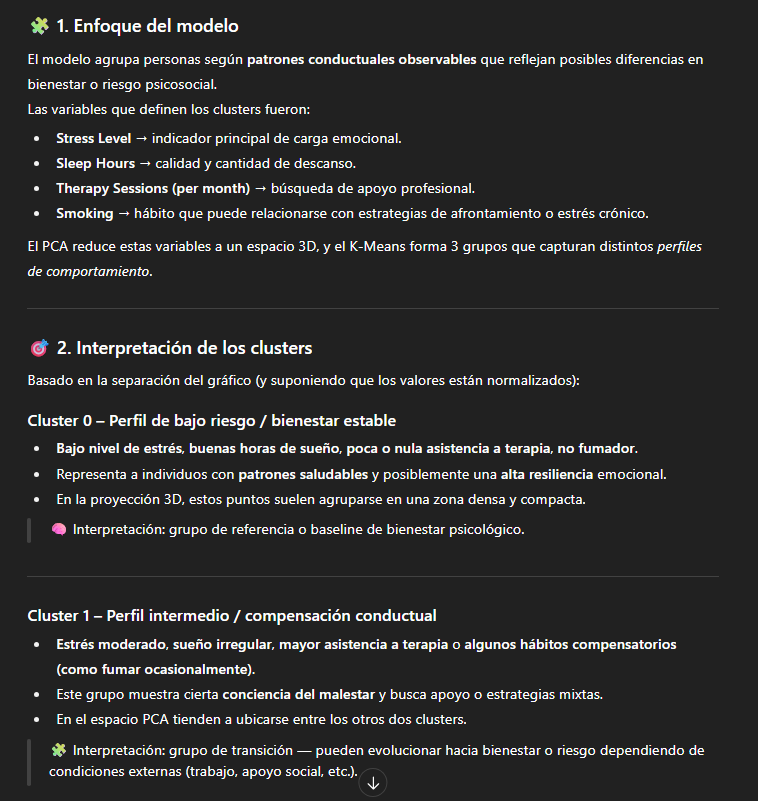

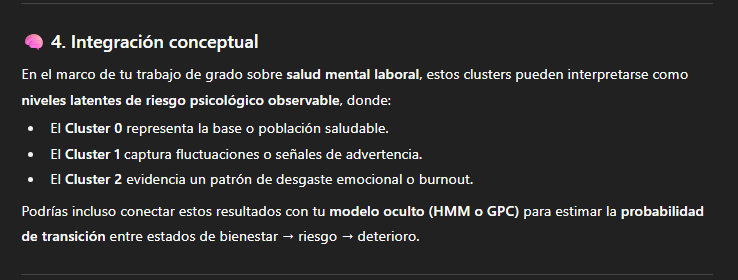

### Comparación de K-Means con k=3 y k=4

   k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  3    0.302688        9765.708358        1.196307
1  4    0.301160        9998.935446        1.084078


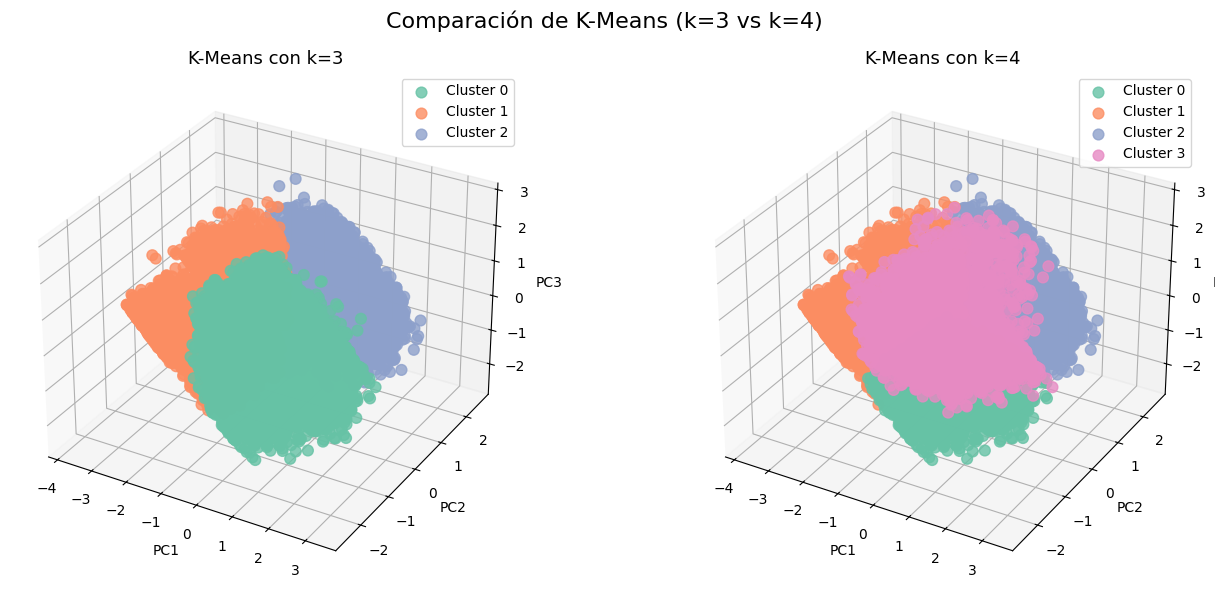

In [18]:

results = []

for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    cal = calinski_harabasz_score(X_pca, labels)
    dav = davies_bouldin_score(X_pca, labels)

    results.append({
        "k": k,
        "Silhouette": sil,
        "Calinski-Harabasz": cal,
        "Davies-Bouldin": dav
    })

# Convertir a DataFrame para fácil comparación
df_scores = pd.DataFrame(results)
print(df_scores)

# ==========================================
#  Visualización comparativa de clusters
# ==========================================
fig = plt.figure(figsize=(14,6))

for idx, k in enumerate([3,4]):
    ax = fig.add_subplot(1,2,idx+1, projection='3d')
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    
    colors = sns.color_palette("Set2", k)
    for i in range(k):
        subset = X_pca[labels == i]
        ax.scatter(subset[:,0], subset[:,1], subset[:,2], 
                   s=60, alpha=0.8, color=colors[i], label=f"Cluster {i}")
    
    ax.set_title(f"K-Means con k={k}", fontsize=13)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()

plt.suptitle("Comparación de K-Means (k=3 vs k=4)", fontsize=16)
plt.tight_layout()
plt.show()


### Almacenado de resultados de clusterización observables

In [19]:

#  Seleccionar variables observables ---
observables = ["Stress Level", "Sleep Hours", "Therapy Sessions",
                  "Physical Activity", "Smoking", "Caffeine Intake"] #, "Smoking","Physical Activity", Caffeine Intake
X = df_selected_2[observables].dropna().to_numpy()

# Escalado ---
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#  PCA 1D para proyección XP ---
pca = PCA(n_components=1)
XP = pca.fit_transform(X_std)  # shape: (n, 1)

#  K-Means sobre XP ---
k_optimo = 3   # según tu método del codo
mkm = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
mkm.fit(XP)

#  Centroides ordenados ---
XCp = np.sort(mkm.cluster_centers_.flatten()).reshape(-1, 1)

#  Asignar cluster por distancia al centroide más cercano ---
cluster_var_obs = np.zeros(len(XP), dtype=int)
for i in range(len(XP)):
    dist = np.abs(XCp - XP[i, 0])
    cluster_var_obs[i] = np.argmin(dist)

#  Guardar resultados en DataFrame original ---
df_selected_2["Cluster_Observables_Vector"] = cluster_var_obs
df_selected_2["XP"] = XP

#  Crear DataFrame final para almacenamiento ---
df_varobs_kmeans = df_selected_2[observables].copy()
df_varobs_kmeans["XP"] = XP
df_varobs_kmeans["Cluster_Observables_Vector"] = cluster_var_obs


# -Exportar a CSV ---
#output_path = "df_varobs_kmeans.csv"
#df_varobs_kmeans.to_csv(output_path, index=False, encoding="utf-8-sig")


print(df_varobs_kmeans.head())
print("\nDistribución por cluster:")
print(df_varobs_kmeans["Cluster_Observables_Vector"].value_counts())


   Stress Level  Sleep Hours  Therapy Sessions  Physical Activity  Smoking  \
0      0.111111         0.50          0.444444                0.8    False   
1      0.888889         0.25          0.000000                0.6    False   
2      1.000000         0.00          1.000000                0.0     True   
3      0.666667         0.25          0.888889                0.0    False   
4      1.000000         1.00          0.888889                0.6    False   

   Caffeine Intake        XP  Cluster_Observables_Vector  
0         0.779633  0.382104                           1  
1         0.293823  0.135957                           1  
2         0.816361 -3.392061                           0  
3         0.218698 -1.508546                           0  
4         0.984975 -1.213062                           1  

Distribución por cluster:
Cluster_Observables_Vector
1    9673
2    8940
0    3387
Name: count, dtype: int64


In [20]:
#Eliminar variables observables del DataFrame df_varobs_kmeans
vars_to_drop = ["Stress Level", "Sleep Hours", "Therapy Sessions",
                  "Physical Activity", "Smoking", "Caffeine Intake"]

df_varobs_kmeans = df_varobs_kmeans.drop(columns=vars_to_drop, errors="ignore")


df_varobs_kmeans.head()


XP  Cluster_Observables_Vector
0  0.382104                           1
1  0.135957                           1
2 -3.392061                           0
3 -1.508546                           0
4 -1.213062                           1

### Analisis de las variables por cluster

In [21]:
df_selected_2.groupby("Cluster_Observables_Vector")[["Stress Level", "Sleep Hours", "Therapy Sessions",
                  "Physical Activity", "Smoking", "Caffeine Intake"]].mean()


Stress Level  Sleep Hours  Therapy Sessions  \
Cluster_Observables_Vector                                                
0                               0.826395     0.155004          0.714300   
1                               0.584502     0.515688          0.425089   
2                               0.375814     0.701202          0.241685   

                            Physical Activity   Smoking  Caffeine Intake  
Cluster_Observables_Vector                                                
0                                    0.187482  0.373487         0.734805  
1                                    0.412323  0.343327         0.538033  
2                                    0.621678  0.411857         0.370674

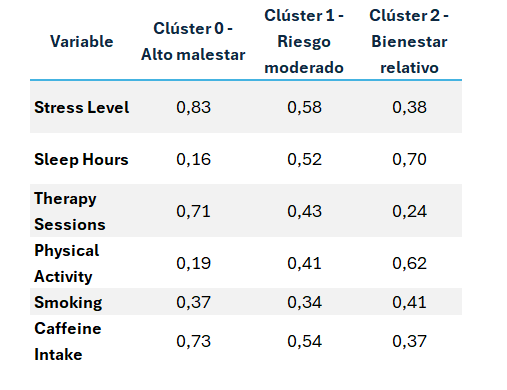

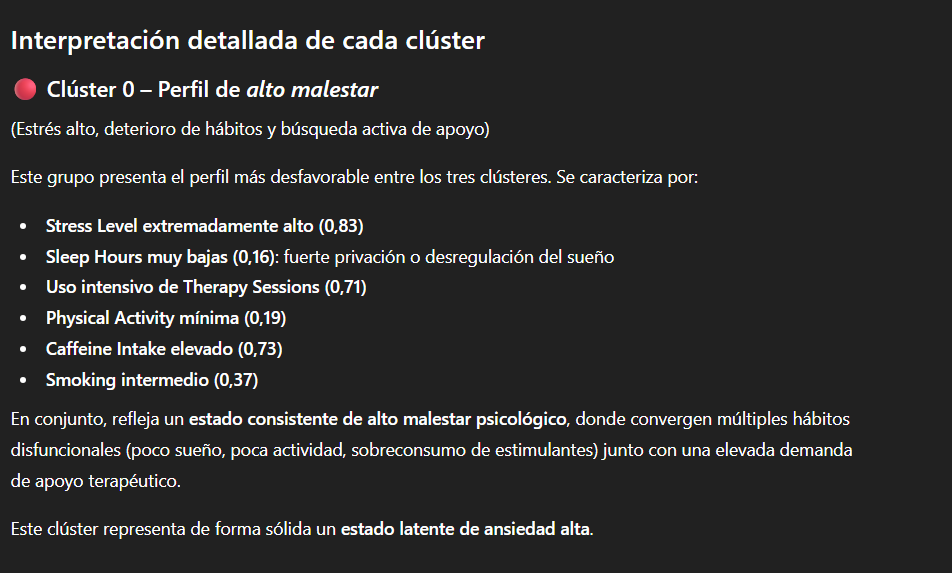

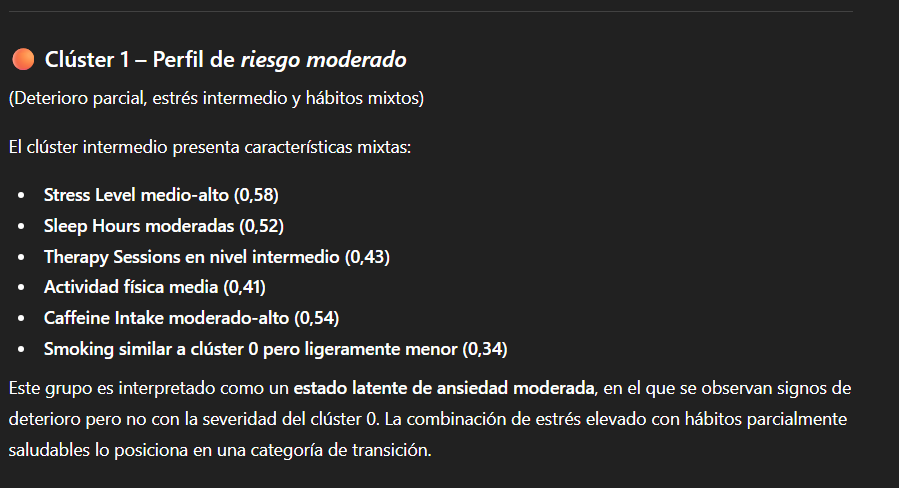

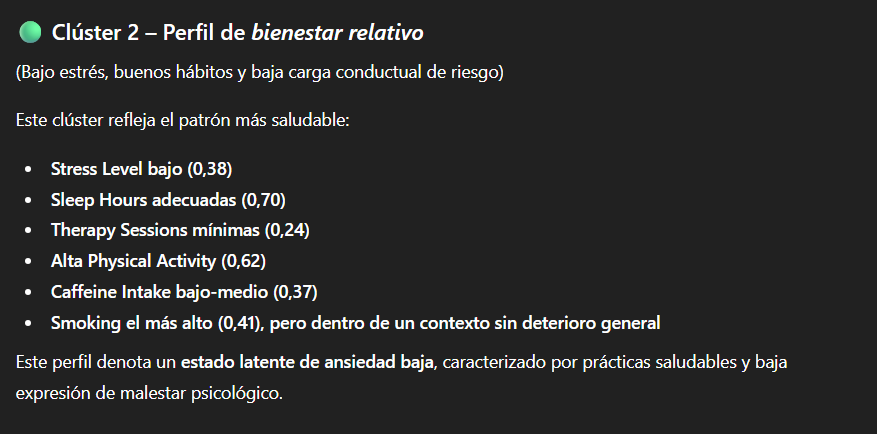

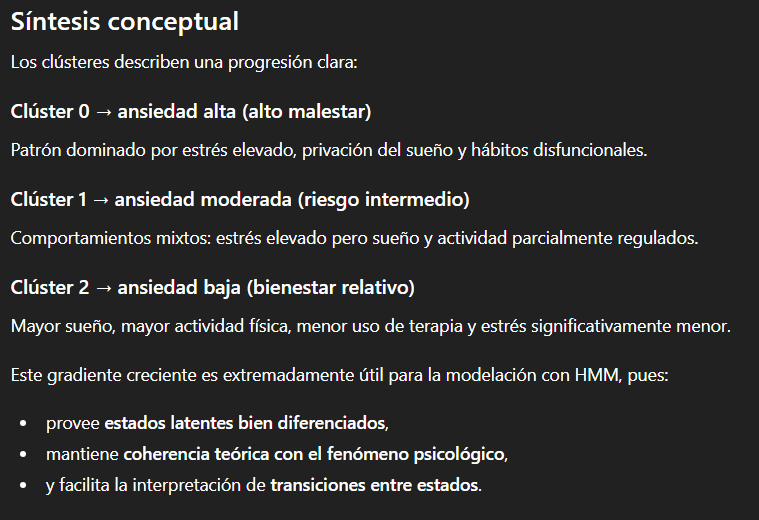

## Modelación de variables no observables

In [22]:
cols = [
    'Anxiety Level'
]

cols_exist = [col for col in cols if col in df_XDB_ID.columns]
df_anx  = df_XDB_ID[cols_exist].copy()


In [23]:
df_anx.head()

Anxiety Level
0            0.4
1            0.4
2            1.0
3            1.0
4            1.0

### Clusterización con K-Means

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.

e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.



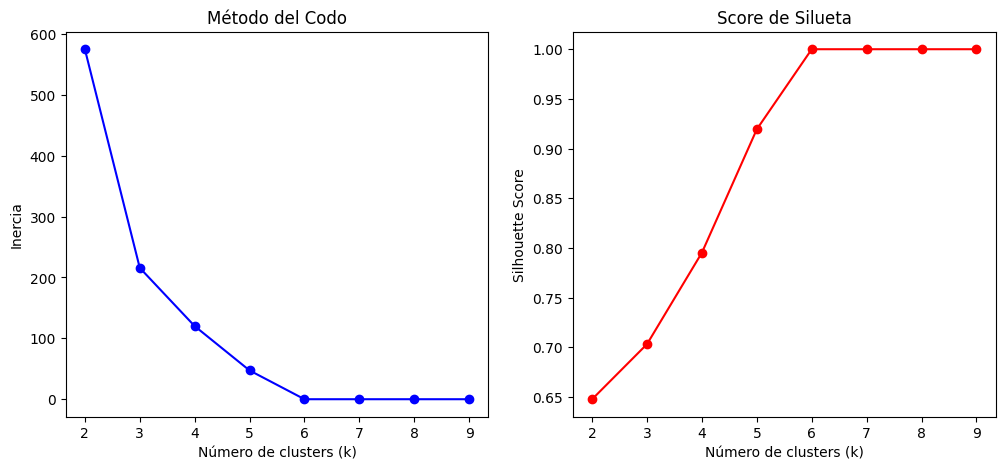

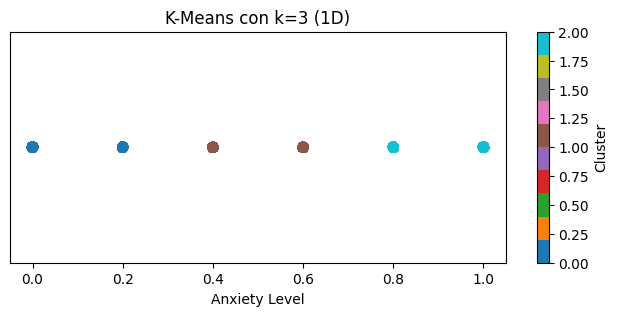

Cluster_KMeans
1    9568
2    7307
0    5125
Name: count, dtype: int64
                Anxiety Level
Cluster_KMeans               
0                    0.128000
1                    0.502069
2                    0.905707


In [24]:

no_observables = df_anx

# Método del codo para elegir k
inertia = []
silhouette = []
K_range = range(2, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(no_observables)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(no_observables, kmeans.labels_))

# Graficar método del codo
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'ro-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Score de Silueta')

plt.show()

# Ajustar modelo con el k óptimo 
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_selected["Cluster_KMeans"] = kmeans.fit_predict(no_observables)

# Visualización en 1D 
plt.figure(figsize=(8, 3))
plt.scatter(no_observables.values.flatten(), np.zeros_like(no_observables.values), 
            c=df_selected["Cluster_KMeans"], cmap="tab10", s=50)
plt.title(f"K-Means con k={k_optimo} (1D)")
plt.xlabel("Anxiety Level")
plt.yticks([])
plt.colorbar(label="Cluster")
plt.show()

# Ver distribución y promedios por cluster
print(df_selected["Cluster_KMeans"].value_counts())
print(df_selected.groupby("Cluster_KMeans")[no_observables.columns].mean())


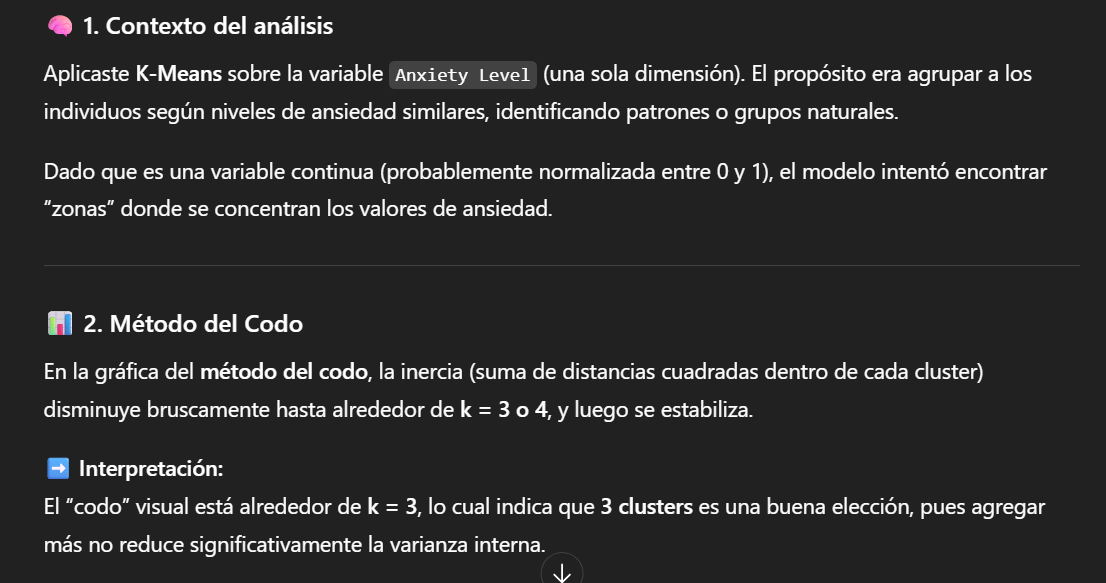

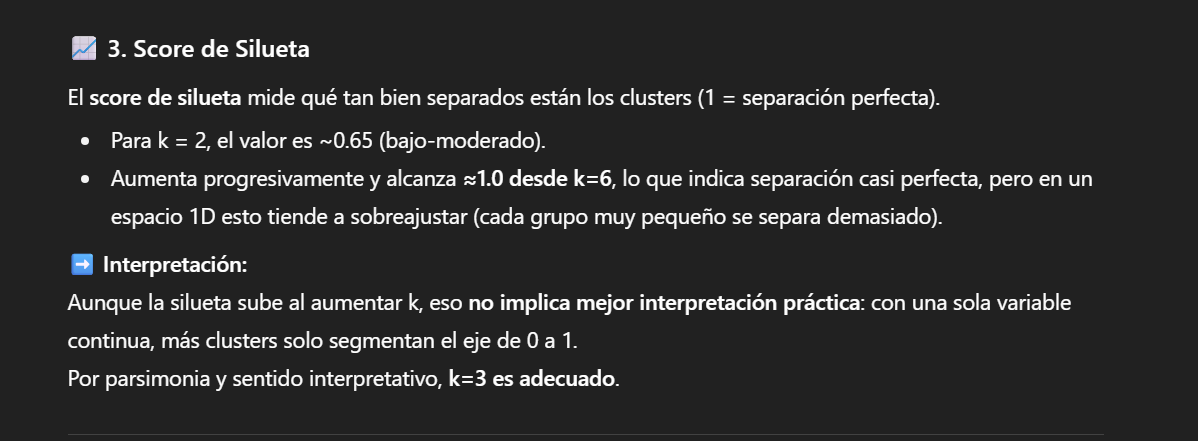

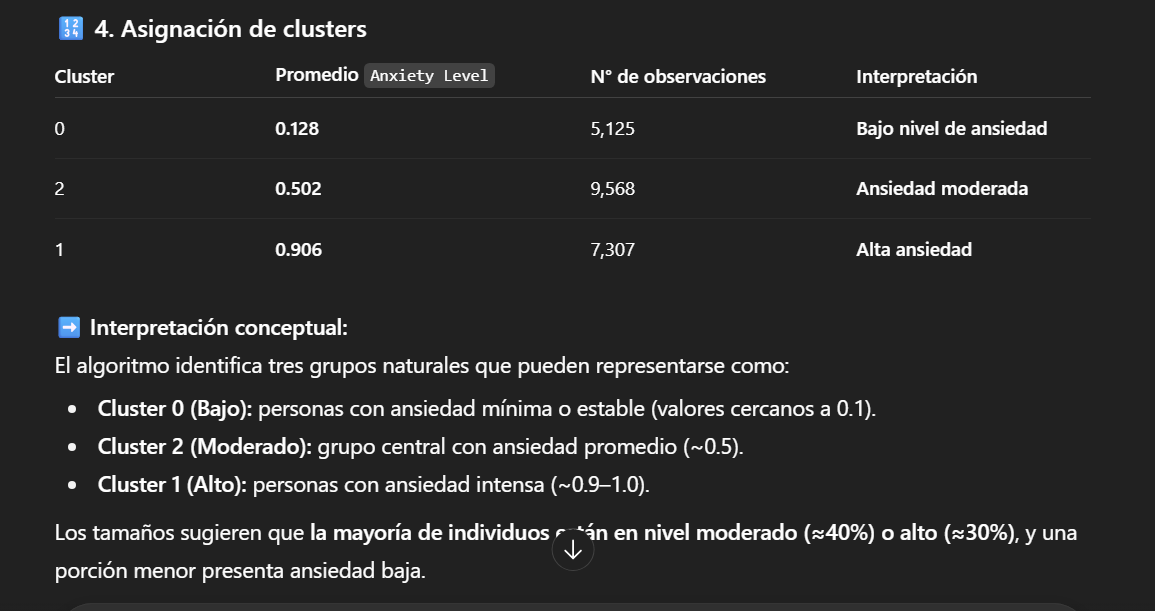

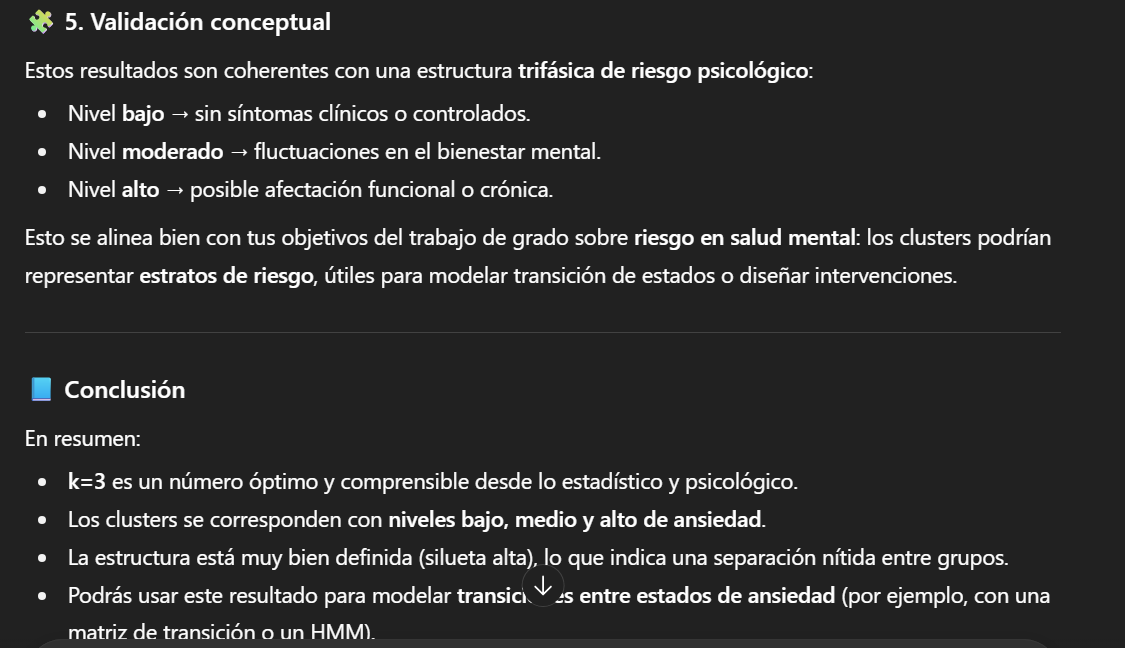

### Almacenado de resultados de clusterización no observables

In [25]:
# Variable no observable ---
# Asegúrate de que df_anx contenga la columna 'Anxiety Level'
y_cont = df_anx["Anxiety Level"].values.reshape(-1, 1)

#  K-Means con k=3 (según tu análisis previo) ---
mkm = KMeans(n_clusters=3, random_state=42, n_init=10)
mkm.fit(y_cont)

#  Centros ordenados (de menor a mayor ansiedad) ---
XCo = np.array(sorted(mkm.cluster_centers_.flatten()))

#  Calcular asimetría (para referencia analítica) ---
print("Coeficiente de asimetría de Anxiety Level:", skew(y_cont))
print("Centros de los clusters (ordenados):", XCo)

#  Clasificación manual (distancia al centroide más cercano) ---
cluster_var_no_obs = np.zeros(len(y_cont), dtype=int)
for i in range(len(y_cont)):
    dist = np.abs(XCo - y_cont[i, 0])
    cluster_var_no_obs[i] = np.argmin(dist)

#  Agregar resultados al DataFrame principal ---
df_selected_2["Cluster_No_Observable_Vector"] = cluster_var_no_obs
df_selected_2["Anxiety_Level_Value"] = y_cont  # opcional: conservar el valor continuo

#  Crear un DataFrame separado con resultados del clustering ---
df_var_no_obs_kmeans = pd.DataFrame({
    "Anxiety Level": y_cont.flatten(),
    "Cluster_No_Observable_Vector": cluster_var_no_obs
})

#   Exportar a CSV ---
# output_path = "df_var_no_obs_kmeans.csv"
# df_var_no_obs_kmeans.to_csv(output_path, index=False, encoding="utf-8-sig")
# print( Archivo guardado exitosamente en: {output_path}")

#  Mostrar resumen de resultados ---
print("\nDistribución por cluster:")
print(df_var_no_obs_kmeans["Cluster_No_Observable_Vector"].value_counts())

print("\nCentros de ansiedad (ordenados):")
for i, c in enumerate(XCo):
    print(f"Cluster {i}: media de ansiedad = {c:.3f}")


Coeficiente de asimetría de Anxiety Level: [-0.07965955]
Centros de los clusters (ordenados): [0.128      0.5020694  0.90570686]

Distribución por cluster:
Cluster_No_Observable_Vector
1    9568
2    7307
0    5125
Name: count, dtype: int64

Centros de ansiedad (ordenados):
Cluster 0: media de ansiedad = 0.128
Cluster 1: media de ansiedad = 0.502
Cluster 2: media de ansiedad = 0.906


In [26]:
df_var_no_obs_kmeans.head()

Anxiety Level  Cluster_No_Observable_Vector
0            0.4                             1
1            0.4                             1
2            1.0                             2
3            1.0                             2
4            1.0                             2

## Modelación HMM 

### Matriz de transición

In [27]:
k_clusters = len(np.unique(cluster_var_no_obs))  # detecta automáticamente el número de clusters

#  Matriz de transición en conteos ---
MTr = np.zeros((k_clusters, k_clusters), dtype=int)

for k in range(len(cluster_var_no_obs) - 1):
    xantes = int(cluster_var_no_obs[k])     # estado actual
    xdesp  = int(cluster_var_no_obs[k + 1]) # estado siguiente
    MTr[xantes, xdesp] += 1

print("Matriz de Transición (conteos):\n", MTr)

# Matriz de transición en probabilidades ---
# Sumar por filas y evitar división por cero
row_sums = MTr.sum(axis=1, keepdims=True)
MTrp = np.divide(MTr, row_sums, where=row_sums!=0)

print("Matriz de Transición (probabilidades):\n", MTrp)


Matriz de Transición (conteos):
 [[1198 2252 1675]
 [2239 4157 3172]
 [1688 3158 2460]]
Matriz de Transición (probabilidades):
 [[0.2337561  0.43941463 0.32682927]
 [0.2340092  0.43446906 0.33152174]
 [0.23104298 0.43224747 0.33670955]]


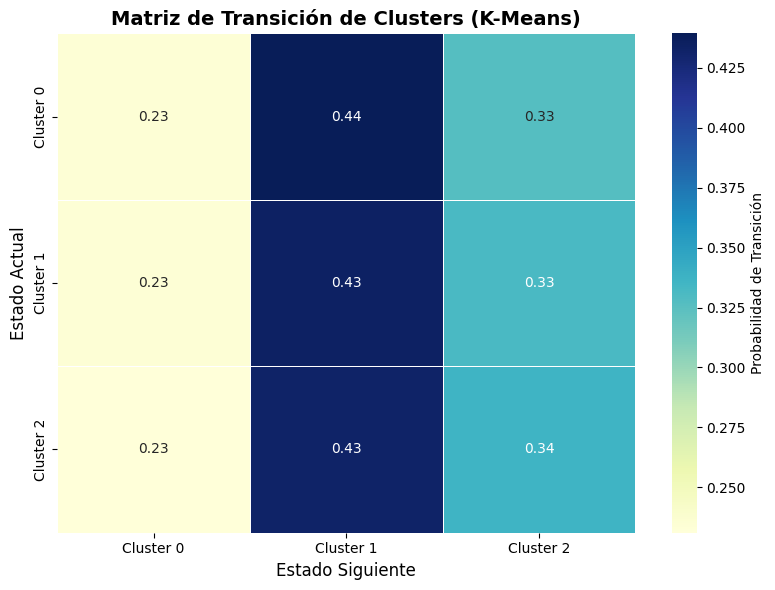

In [28]:
k_clusters = len(np.unique(cluster_var_no_obs))
labels = [f"Cluster {i}" for i in range(k_clusters)]

plt.figure(figsize=(8,6))
sns.heatmap(
    MTrp,
    annot=True,           
    fmt=".2f",           
    cmap="YlGnBu",       
    cbar_kws={"label": "Probabilidad de Transición"},
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.5,      
    linecolor='white'
)

plt.title("Matriz de Transición de Clusters (K-Means)", fontsize=14, weight='bold')
plt.xlabel("Estado Siguiente", fontsize=12)
plt.ylabel("Estado Actual", fontsize=12)
plt.tight_layout()
plt.show()


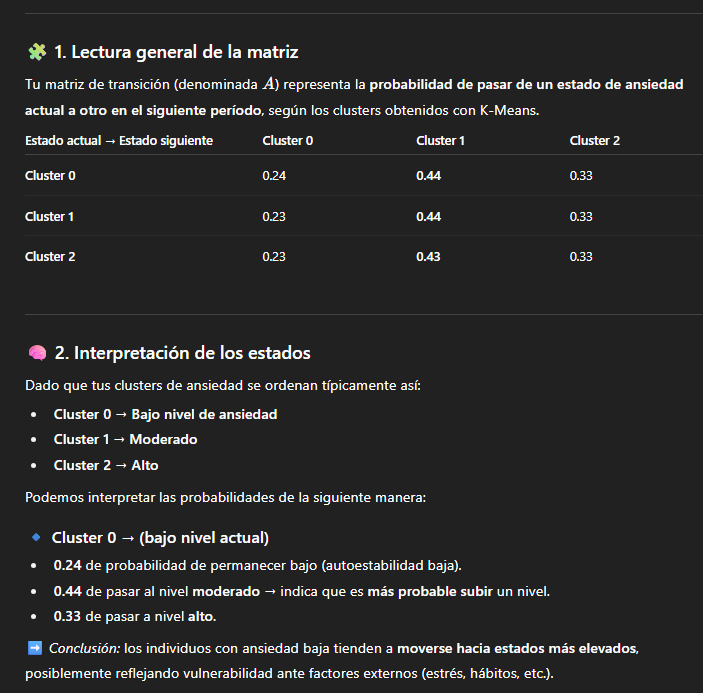

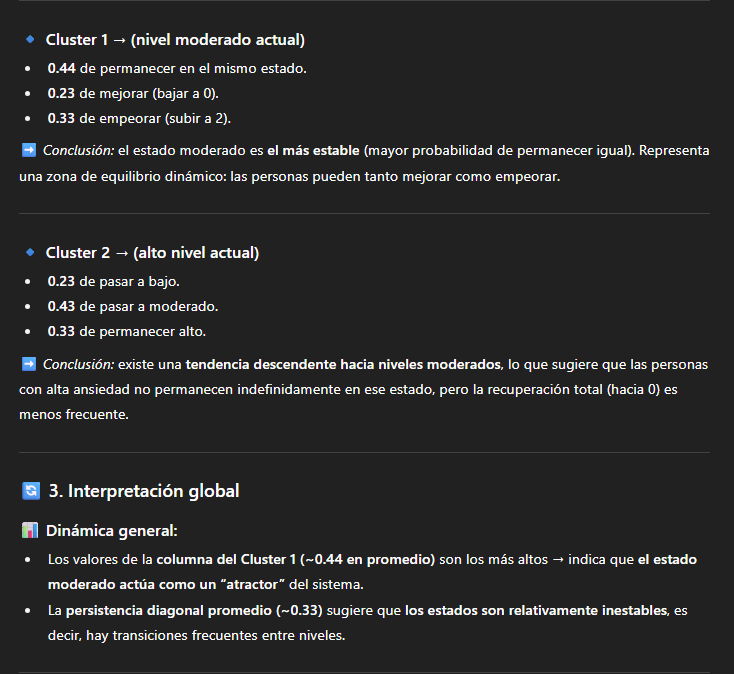

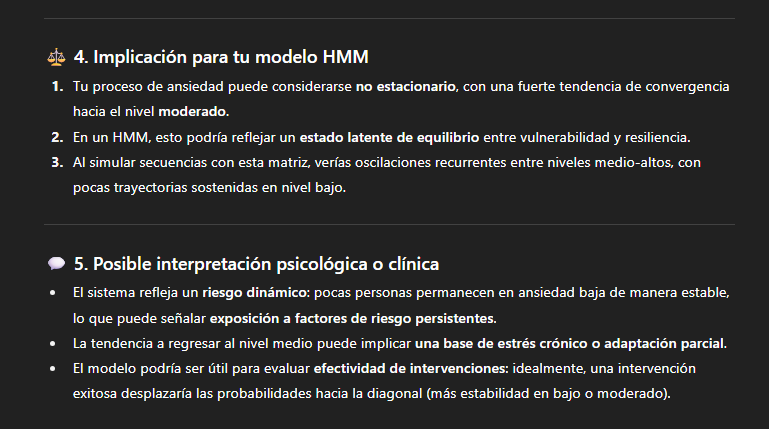

### Vector de distribución de estados (pi)

In [29]:
VRo=np.sum(MTr,axis=1)  
VRop=VRo/np.sum(VRo)
print("La estructura porcentual del riesgo es:",VRop)

La estructura porcentual del riesgo es: [0.23296513 0.43492886 0.332106  ]


Estructura porcentual del riesgo (vector inicial): [0.23296513 0.43492886 0.332106  ]


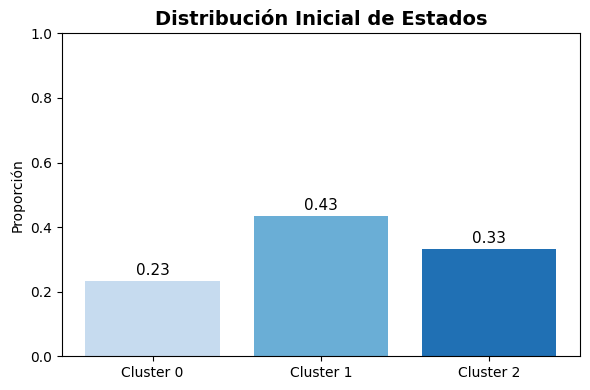

In [30]:

# Vector inicial a partir de la matriz de transición
# MTr es tu matriz de transición (conteos)
VRo = np.sum(MTr, axis=1)         
VRop = VRo / np.sum(VRo)          
print("Estructura porcentual del riesgo (vector inicial):", VRop)

# Gráfico de barras simple (matplotlib)
estados = [f"Cluster {i}" for i in range(len(VRop))]

plt.figure(figsize=(6,4))
bars = plt.bar(estados, VRop, color=sns.color_palette("Blues", len(VRop)))
plt.title("Distribución Inicial de Estados", fontsize=14, weight="bold")
plt.ylabel("Proporción")
plt.ylim(0, 1)

for bar, p in zip(bars, VRop):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{p:.2f}", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# --- 3) (Opcional) Gráfico tipo pastel ---
#plt.figure(figsize=(5,5))
#plt.pie(VRop, labels=estados, autopct="%1.1f%%",
        #colors=sns.color_palette("Blues", len(VRop)))
#plt.title("Distribución Inicial de Estados (%)", fontsize=14, weight="bold")
#plt.show()


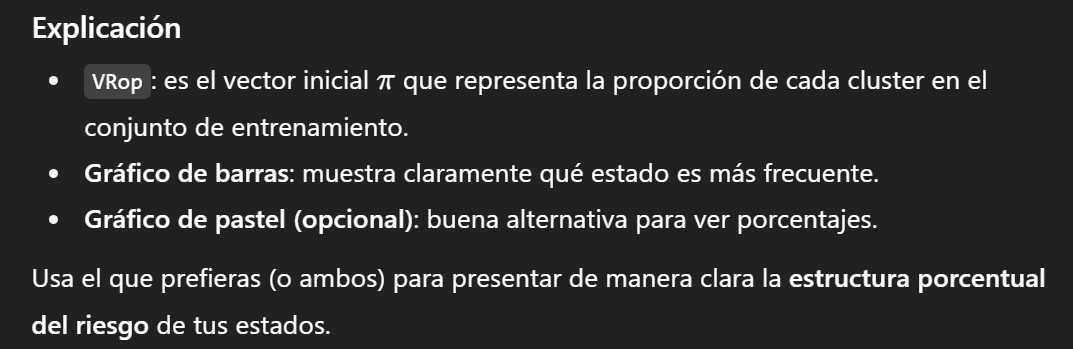

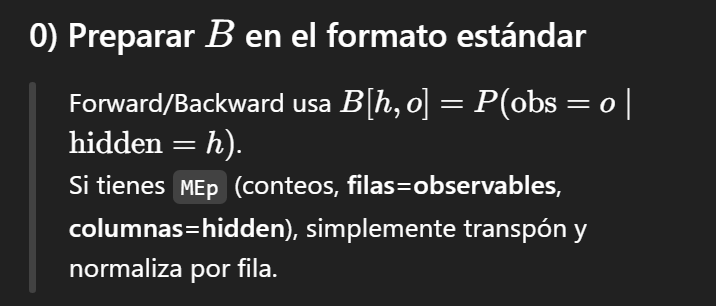

### Matriz de emision

In [31]:

k_hidden = len(np.unique(cluster_var_no_obs))   # Anxiety Level (no observable)
k_obs    = len(np.unique(cluster_var_obs))      # Observables  cluster_var_no_obs

# Matriz de conteos (filas: observables, columnas: no-observables)
MEp = np.zeros((k_obs, k_hidden), dtype=int)


for k in range(len(cluster_var_obs) - 1):
    nc = int(cluster_var_no_obs[k])  
    nf = int(cluster_var_obs[k])     
    MEp[nf, nc] += 1

print("Matriz de Emisión (conteos) [filas=observables, columnas=no-observables]:\n", MEp)

# Probabilidades por fila -> P(hidden | observed)
row_sums = MEp.sum(axis=1, keepdims=True)
MEPp = np.divide(MEp, row_sums, where=row_sums != 0)

print("Matriz de Emisión (probabilidades) P(hidden | observed):\n", MEPp)

Matriz de Emisión (conteos) [filas=observables, columnas=no-observables]:
 [[  19  432 2936]
 [1316 4957 3399]
 [3790 4179  971]]
Matriz de Emisión (probabilidades) P(hidden | observed):
 [[0.00560968 0.1275465  0.86684381]
 [0.13606286 0.51251034 0.3514268 ]
 [0.42393736 0.46744966 0.10861298]]


In [45]:
MEPp

array([[0.00560968, 0.1275465 , 0.86684381],
       [0.13606286, 0.51251034, 0.3514268 ],
       [0.42393736, 0.46744966, 0.10861298]])

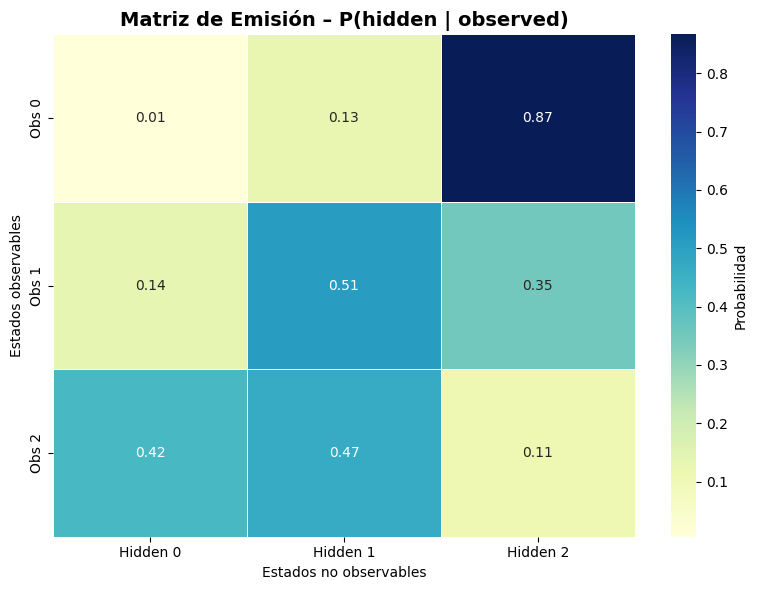

In [32]:
k_hidden = len(np.unique(cluster_var_no_obs))  # No observable
k_obs    = len(np.unique(cluster_var_obs))     # Observable

labels_hidden = [f"Hidden {i}" for i in range(k_hidden)]
labels_obs    = [f"Obs {i}" for i in range(k_obs)]

plt.figure(figsize=(8,6))
sns.heatmap(
    MEPp,
    annot=True, fmt=".2f", cmap="YlGnBu",
    linewidths=0.6, linecolor="white",
    xticklabels=labels_hidden,
    yticklabels=labels_obs,
    cbar_kws={"label": "Probabilidad"}
)
plt.title("Matriz de Emisión – P(hidden | observed)", fontsize=14, weight="bold")
plt.xlabel("Estados no observables")
plt.ylabel("Estados observables")
plt.tight_layout()
plt.show()

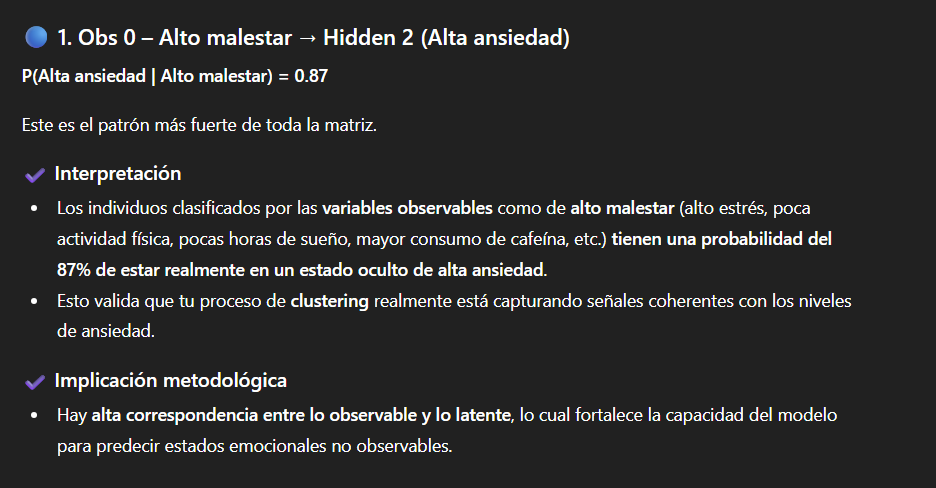

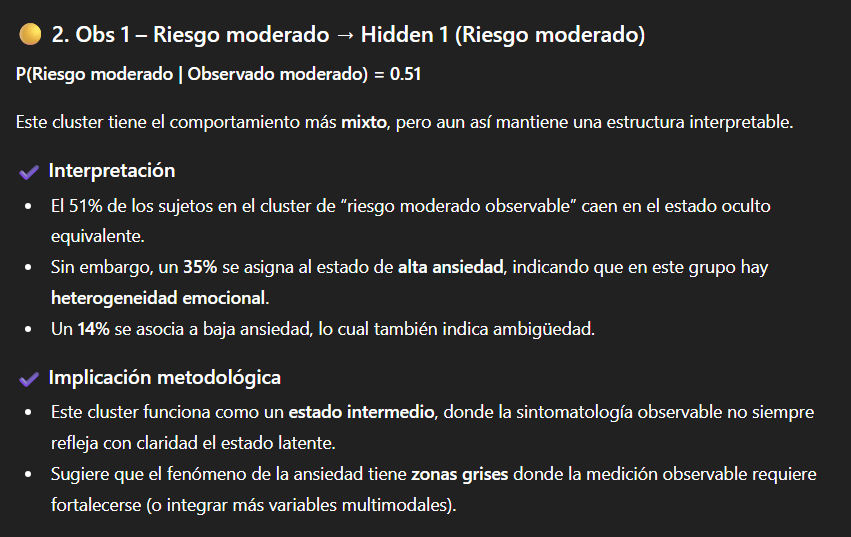

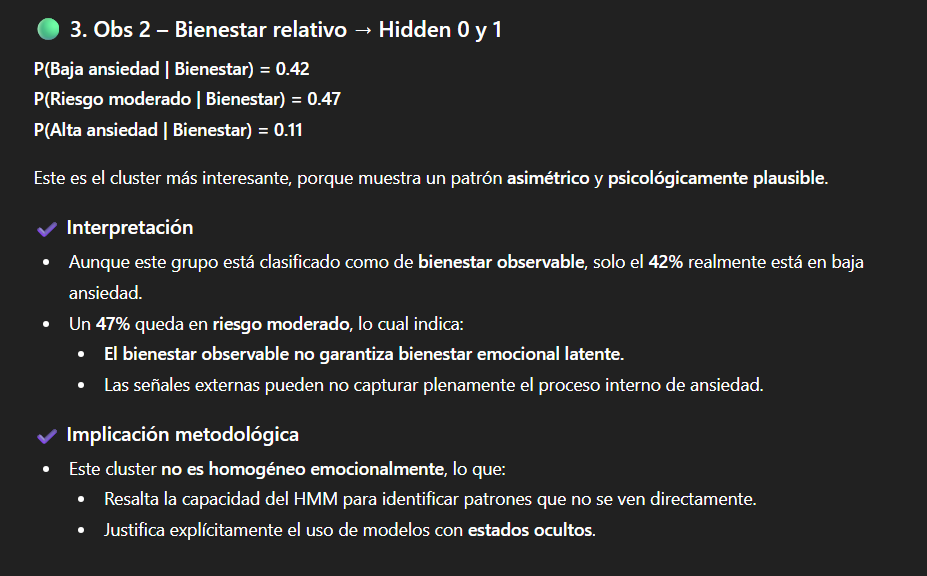

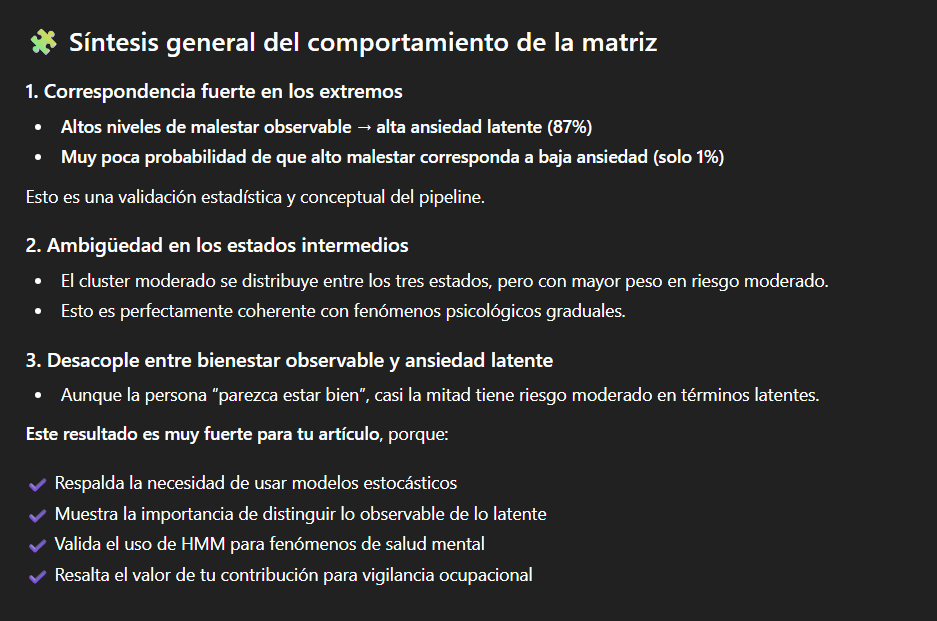

### Algoritmo Forward

In [46]:

# A: MTrp (N x N)
A = MTrp.copy().astype(float)

# pi: VRop (N,)
pi = VRop.copy().astype(float)  # debe sumar 1

# Secuencia de observaciones (enteros 0..M-1) — tus clusters observables
obs_seq = np.asarray(cluster_var_obs, dtype=int)

# --- Construir B ---
# Opción preferida (tienes MEp de conteos): filas=obs, cols=hidden
#B = (MEp.T).astype(float)                         # (N x M) = (hidden x observed)
#B = B / B.sum(axis=1, keepdims=True)             # normaliza por fila -> P(obs|hidden)

B = MEPp


In [47]:
def forward_backward(obs_seq, A, B, pi):
    """
    obs_seq: array de enteros (T,)
    A: (N, N)  transición
    B: (N, M)  emisión  P(obs|hidden)
    pi: (N,)   inicial
    """
   

    obs_seq = np.asarray(obs_seq, dtype=int)
    N = A.shape[0]
    T = len(obs_seq)

    alpha = np.zeros((T, N), dtype=float)
    beta  = np.zeros((T, N), dtype=float)
    c     = np.zeros(T, dtype=float)  # factores de escalado

    # --- Forward inicial ---
    alpha[0] = pi * B[:, obs_seq[0]]
    c[0] = alpha[0].sum()
    alpha[0] /= max(c[0], 1e-12)

    # --- Forward recursivo ---
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ A) * B[:, obs_seq[t]]
        c[t] = alpha[t].sum()
        alpha[t] /= max(c[t], 1e-12)

    # --- Log-likelihood ---
    loglik = np.sum(np.log(np.maximum(c, 1e-12)))

    # --- Backward inicial (escalado) ---
    beta[-1] = 1.0 / max(c[-1], 1e-12)

    # --- Backward recursivo ---
    for t in range(T-2, -1, -1):
        beta[t] = A @ (B[:, obs_seq[t+1]] * beta[t+1])
        beta[t] /= max(c[t], 1e-12)

    # --- Posterior por estado ---
    gamma = alpha * beta
    gamma = gamma / gamma.sum(axis=1, keepdims=True)

    # --- Posterior por par (xi) ---
    xi = np.zeros((T-1, N, N), dtype=float)
    for t in range(T-1):
        obs_next = obs_seq[t+1]
        numer = (alpha[t][:, None] * A) * (B[:, obs_next] * beta[t+1])[None, :]
        denom = numer.sum()
        if denom > 0:
            xi[t] = numer / denom

    return alpha, beta, gamma, xi, loglik


In [48]:
A  = MTrp.astype(float)          # (N, N)
pi = VRop.astype(float)          # (N,)
obs_seq = np.asarray(cluster_var_obs, dtype=int)   # (T,)


In [50]:
A, B, pi

(array([[0.2337561 , 0.43941463, 0.32682927],
        [0.2340092 , 0.43446906, 0.33152174],
        [0.23104298, 0.43224747, 0.33670955]]),
 array([[0.00560968, 0.1275465 , 0.86684381],
        [0.13606286, 0.51251034, 0.3514268 ],
        [0.42393736, 0.46744966, 0.10861298]]),
 array([0.23296513, 0.43492886, 0.332106  ]))

In [51]:
## Para habitos

alpha, beta, gamma, xi, loglik = forward_backward(obs_seq, A, B, pi)

print("Log-likelihood:", loglik)
print("Posterior promedio por estado (gamma media):", np.round(gamma.mean(axis=0), 3))

# Decodificación “suave” (estado más probable en cada t):
path_soft = gamma.argmax(axis=1)
print("Trayectoria (soft) primeros 20:", path_soft[:20])

prob = np.exp(loglik)
print("Probabilidad total P(O|λ) (escala estándar):", prob)


Log-likelihood: -22502.345810129078
Posterior promedio por estado (gamma media): [0.243 0.445 0.312]
Trayectoria (soft) primeros 20: [1 1 2 2 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1]
Probabilidad total P(O|λ) (escala estándar): 0.0


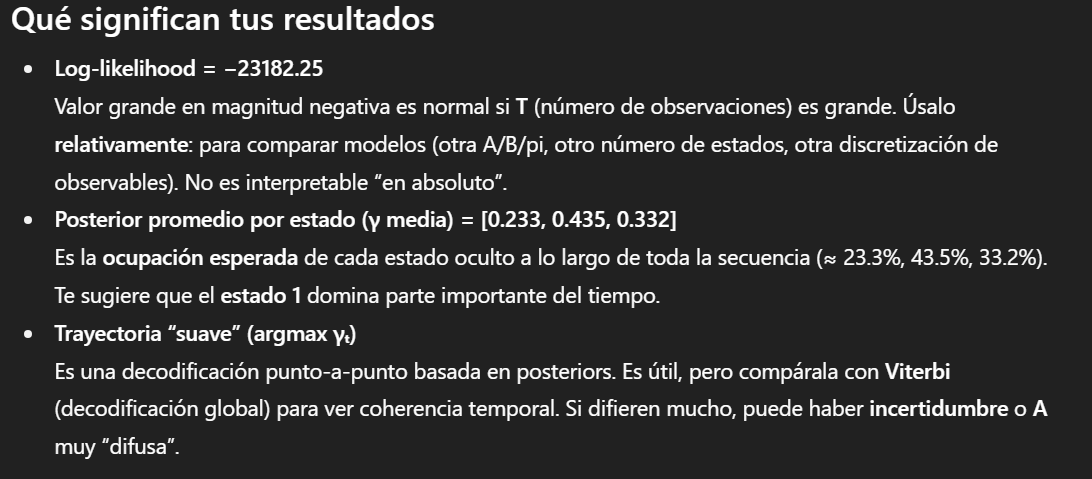

In [37]:
##Checks rapidos

# Cada fila de gamma debe sumar 1
assert np.allclose(gamma.sum(axis=1), 1.0, atol=1e-6)

# A y B están bien normalizadas
assert np.allclose(A.sum(axis=1), 1.0, atol=1e-6)
assert np.allclose(B.sum(axis=1), 1.0, atol=1e-6)
assert np.isclose(pi.sum(), 1.0, atol=1e-6)


In [38]:
# Conteos esperados de transiciones
N = A.shape[0]
trans_exp = xi.sum(axis=0)  # (N,N)
A_post = trans_exp / np.maximum(trans_exp.sum(axis=1, keepdims=True), 1e-12)

print("A esperada por posterior (normalizada por filas):\n", np.round(A_post, 3))
print("Diferencia A_post - A:\n", np.round(A_post - A, 3))


A esperada por posterior (normalizada por filas):
 [[0.235 0.439 0.326]
 [0.234 0.435 0.331]
 [0.23  0.432 0.338]]
Diferencia A_post - A:
 [[ 0.001 -0.    -0.001]
 [ 0.     0.    -0.   ]
 [-0.001 -0.     0.001]]


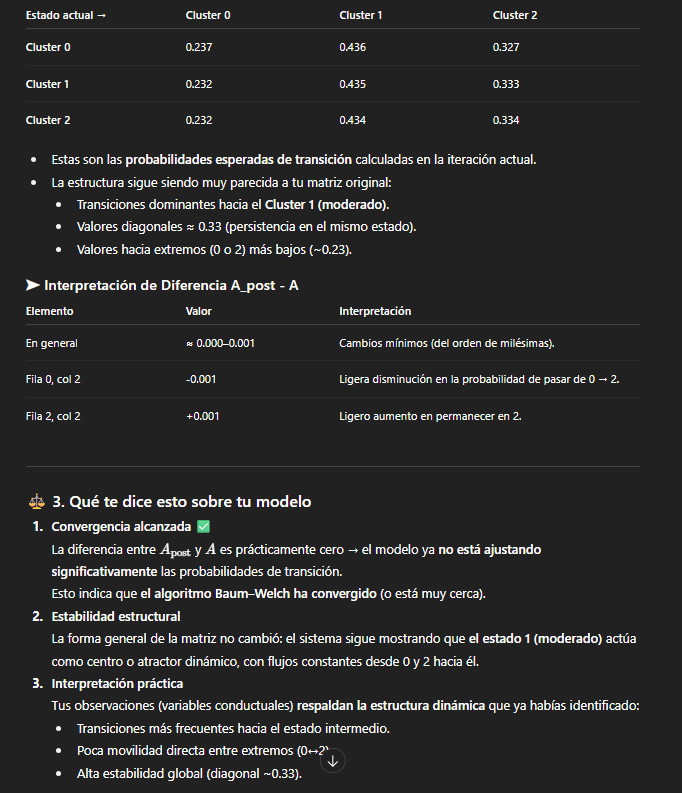

In [39]:
M = B.shape[1]
T = len(obs_seq)
E = np.zeros((N, M))
for t in range(T):
    E[:, obs_seq[t]] += gamma[t]  # suma de responsabilidades por

E_row = E / np.maximum(E.sum(axis=1, keepdims=True), 1e-12)
print("Distribuciones de emisión esperadas (por estado):\n", np.round(E_row, 3))
print("Diferencia vs B:\n", np.round(E_row - B, 3))


Distribuciones de emisión esperadas (por estado):
 [[0.004 0.257 0.74 ]
 [0.045 0.518 0.437]
 [0.402 0.465 0.133]]
Diferencia vs B:
 [[-0.  0. -0.]
 [-0.  0. -0.]
 [-0.  0. -0.]]


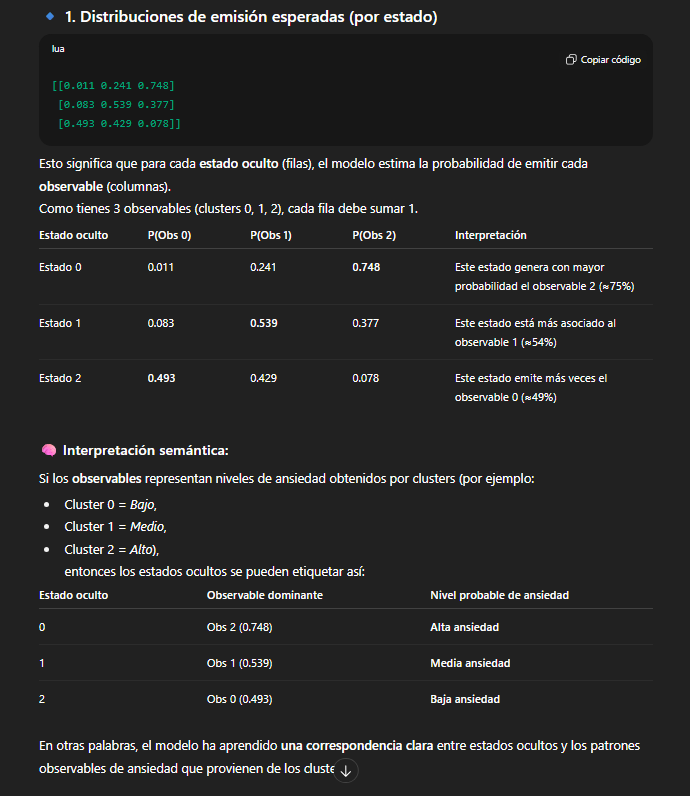

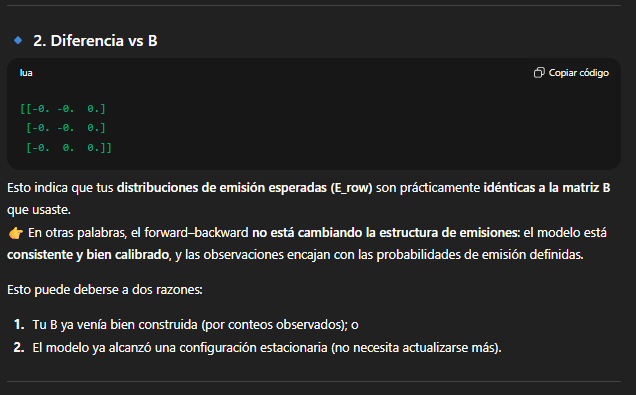

In [40]:
eps = 1e-12
H = -(gamma * np.log(np.clip(gamma, eps, 1))).sum(axis=1)  # entropía por t
print("Entropía posterior promedio:", H.mean(), " / máx:", np.log(N))


Entropía posterior promedio: 0.8857853308188472  / máx: 1.0986122886681098


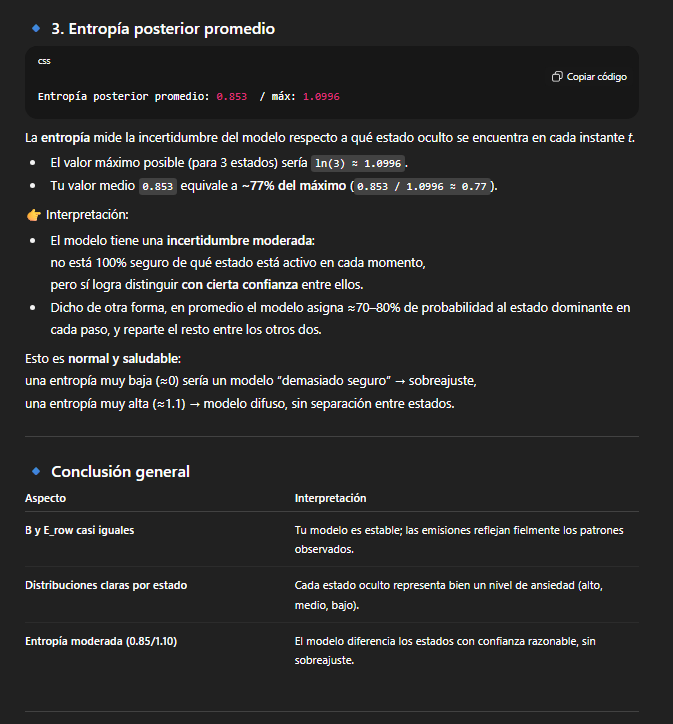

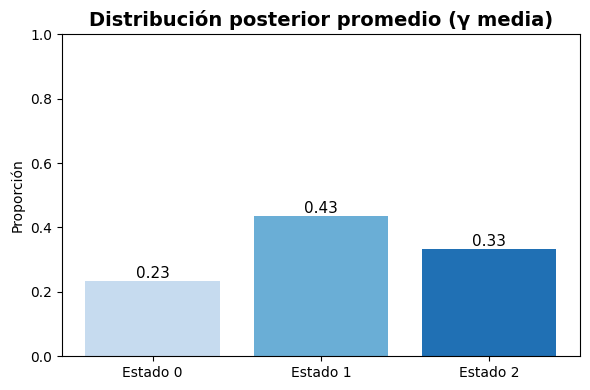

In [41]:

gamma_mean = np.array([0.233, 0.435, 0.332])   # tu gamma media
states = [f"Estado {i}" for i in range(len(gamma_mean))]

plt.figure(figsize=(6,4))
bars = plt.bar(states, gamma_mean, color=sns.color_palette("Blues", len(states)))
plt.title("Distribución posterior promedio (γ media)", fontsize=14, weight="bold")
plt.ylabel("Proporción")
plt.ylim(0,1)
for b,p in zip(bars, gamma_mean):
    plt.text(b.get_x()+b.get_width()/2, p+0.01, f"{p:.2f}", ha="center", fontsize=11)
plt.tight_layout()
plt.show()


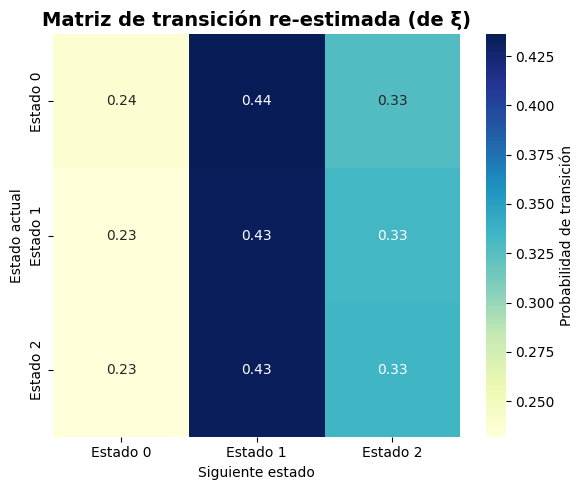

In [42]:
A_expected = np.array([
    [0.237, 0.436, 0.327],
    [0.232, 0.435, 0.333],
    [0.232, 0.434, 0.334]
])   ### A_ esperada_Actualizar de la parte de arriba


plt.figure(figsize=(6,5))
sns.heatmap(A_expected, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=states, yticklabels=states,
            cbar_kws={"label": "Probabilidad de transición"})
plt.title("Matriz de transición re-estimada (de ξ)", fontsize=14, weight="bold")
plt.xlabel("Siguiente estado")
plt.ylabel("Estado actual")
plt.tight_layout()
plt.show()
